### **SISTEMA INTELIGENTE DE SCORING CREDITICIO CON REDES NEURONALES PROFUNDAS**

#### <strong><font color="green">üéØ Objetivo</font></strong>

Dise√±ar, entrenar y evaluar un modelo de red neuronal profunda para predecir la probabilidad de impago de clientes bancarios, utilizando un conjunto de datos realista. El modelo debe ser explicable, eficiente y presentar resultados interpretables para su uso en contextos financieros.

#### <strong><font color="green">Entorno de ejecuci√≥n.</font></strong>

Para este proyecto se utilizar√° el entorno de ejecuci√≥n de Jupyter Notebook. La versi√≥n de python es la 3.12.10 con las siguientes librer√≠as:

- numpy==1.26.4
- pandas==2.2.2
- scipy==1.11.4
- matplotlib==3.9.2
- seaborn==0.13.2
- plotly==5.24.1
- scikit-learn==1.7.1
- shap==0.48.0
- imblearn==0.0
- tensorflow==2.19.0

In [1]:
# Se importan las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import funciones as f
import random

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks

import shap

import warnings
warnings.filterwarnings("ignore")

C:\Users\Jose\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuraci√≥n de visualizaci√≥n
plt.style.use('ggplot')
sns.set_palette("husl")

In [3]:
# Reproducibilidad
SEED = 42                   # Fija la semilla para garantizar reproducibilidad en resultados aleatorios
random.seed(SEED)           # Establece la semilla para la generaci√≥n de n√∫meros aleatorios en Python
np.random.seed(SEED)        # Establece la semilla para la generaci√≥n de n√∫meros aleatorios en NumPy
tf.random.set_seed(SEED)    # Establece la semilla para la generaci√≥n de n√∫meros aleatorios en TensorFlow

#### <strong><font color="green">1. Carga y an√°lisis de datos</font></strong>

In [4]:
# Carga el dataset
df = pd.read_csv("german_credit_data.csv")

##### <strong><font color="DarkSeaGreen">üî∏Exploraci√≥n de datos</font></strong>

üìå **Descripci√≥n de variables**

- `status:` Estado de la cuenta corriente existente (codificado en categor√≠as).
- `duration:` Duraci√≥n del cr√©dito en meses.
- `credit_history:` Historial de cr√©dito del cliente (pago puntual, retrasos, cr√©ditos previos).
- `purpose:` Prop√≥sito del cr√©dito (ejemplo: coche, electrodom√©sticos, educaci√≥n, etc.).
- `amount:` Monto del cr√©dito solicitado (en marcos alemanes).
- `savings:` Cantidad de ahorros del cliente (codificado en categor√≠as).
- `employment_duration:` Tiempo de empleo actual (en categor√≠as de a√±os).
- `installment_rate:` Tasa de cuota en relaci√≥n al ingreso disponible (%).
- `personal_status_sex:` Estado civil y g√©nero del cliente (codificado).
- `other_debtors:` Otros deudores o garantes asociados.
- `present_residence:` Tiempo de residencia actual (en a√±os).
- `property:` Tipo de propiedad pose√≠da (ejemplo: bienes ra√≠ces, seguro, etc.).
- `age:` Edad del cliente (en a√±os).
- `other_installment_plans:` Otros planes de pago a plazos (ejemplo: banco, tienda).
- `housing:` Tipo de vivienda (propia, alquilada, libre).
- `number_credits:` N√∫mero de cr√©ditos existentes en el banco.
- `job:` Tipo de empleo (codificado en niveles de estabilidad/posici√≥n).
- `people_liable:` N√∫mero de personas a cargo econ√≥micamente.
- `telephone:` Disponibilidad de tel√©fono (1 = s√≠, 0 = no).
- `foreign_worker:` Condici√≥n de trabajador extranjero (1 = s√≠, 0 = no).
- `credit_risk:` Variable objetivo. Indica la calidad del cr√©dito (1 = buen cliente, 0 = cliente riesgoso).

---

üìã **Clasificaci√≥n de variables**

| Variable                   | Tipo        | Escala              | Descripci√≥n breve |
|-----------------------------|------------|---------------------|------------------|
| **status**                  | Categ√≥rica | Ordinal             | Estado de la cuenta corriente |
| **duration**                | Num√©rica   | Continua            | Duraci√≥n del cr√©dito (meses) |
| **credit_history**          | Categ√≥rica | Nominal             | Historial de cr√©dito |
| **purpose**                 | Categ√≥rica | Nominal             | Prop√≥sito del cr√©dito |
| **amount**                  | Num√©rica   | Continua            | Monto del cr√©dito |
| **savings**                 | Categ√≥rica | Ordinal             | Nivel de ahorros |
| **employment_duration**     | Categ√≥rica | Ordinal             | Tiempo en el empleo actual |
| **installment_rate**        | Categ√≥rica | Ordinal             | Tasa de cuota (%) |
| **personal_status_sex**     | Categ√≥rica | Nominal             | Estado civil y sexo |
| **other_debtors**           | Categ√≥rica | Nominal             | Otros deudores/garantes |
| **present_residence**       | Categ√≥rica | Ordinal             | Tiempo de residencia actual |
| **property**                | Categ√≥rica | Nominal             | Tipo de propiedad |
| **age**                     | Num√©rica   | Continua            | Edad (a√±os) |
| **other_installment_plans** | Categ√≥rica | Nominal             | Otros planes de pago |
| **housing**                 | Categ√≥rica | Nominal             | Tipo de vivienda |
| **number_credits**          | Categ√≥rica | Ordinal             | N√∫mero de cr√©ditos en el banco |
| **job**                     | Categ√≥rica | Nominal             | Tipo de empleo |
| **people_liable**           | Categ√≥rica | Ordinal             | Personas a cargo |
| **telephone**               | Categ√≥rica | Nominal             | Disponibilidad de tel√©fono |
| **foreign_worker**          | Categ√≥rica | Nominal             | Condici√≥n de trabajador extranjero |
| **credit_risk**             | Categ√≥rica | Binaria (objetivo)  | Riesgo de cr√©dito (1 = bueno, 0 = malo) |

In [5]:
# Inspecci√≥n inicial de los datos
print("üîπ Primeras filas del dataset:")
df.head()

üîπ Primeras filas del dataset:


status  duration  credit_history  purpose  amount  savings  \
0       1        18               4        2    1049        1   
1       1         9               4        0    2799        1   
2       2        12               2        9     841        2   
3       1        12               4        0    2122        1   
4       1        12               4        0    2171        1   

   employment_duration  installment_rate  personal_status_sex  other_debtors  \
0                    2                 4                    2              1   
1                    3                 2                    3              1   
2                    4                 2                    2              1   
3                    3                 3                    3              1   
4                    3                 4                    3              1   

   ...  property  age  other_installment_plans  housing  number_credits  job  \
0  ...         2   21                        3        1               1    3   
1  ...         1   36                        3        1               2    3   
2  ...         1   23                        3        1               1    2   
3  ...         1   39                        3        1               2    2   
4  ...         2   38                        1        2               2    2   

   people_liable  telephone  foreign_worker  credit_risk  
0              2          1               2            1  
1              1          1               2            1  
2              2          1               2            1  
3              1          1               1            1  
4              2          1               1            1  

[5 rows x 21 columns]

In [6]:
# Ver informaci√≥n general del dataset
print("üîπ Informaci√≥n general del dataset:\n")
df.info()

üîπ Informaci√≥n general del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   status                   1000 non-null   int64
 1   duration                 1000 non-null   int64
 2   credit_history           1000 non-null   int64
 3   purpose                  1000 non-null   int64
 4   amount                   1000 non-null   int64
 5   savings                  1000 non-null   int64
 6   employment_duration      1000 non-null   int64
 7   installment_rate         1000 non-null   int64
 8   personal_status_sex      1000 non-null   int64
 9   other_debtors            1000 non-null   int64
 10  present_residence        1000 non-null   int64
 11  property                 1000 non-null   int64
 12  age                      1000 non-null   int64
 13  other_installment_plans  1000 non-null   int64
 14  housing          

In [7]:
# Visualizaci√≥n de dimensiones del dataset
print("üîπ Dimensiones:", df.shape)     # Resultado (filas, columnas)

üîπ Dimensiones: (1000, 21)


In [8]:
# Estad√≠sticas descriptivas
print("üîπ Estad√≠sticas descriptivas de variables num√©ricas:")
df.describe()

üîπ Estad√≠sticas descriptivas de variables num√©ricas:


status     duration  credit_history      purpose       amount  \
count  1000.000000  1000.000000      1000.00000  1000.000000   1000.00000   
mean      2.577000    20.903000         2.54500     2.828000   3271.24800   
std       1.257638    12.058814         1.08312     2.744439   2822.75176   
min       1.000000     4.000000         0.00000     0.000000    250.00000   
25%       1.000000    12.000000         2.00000     1.000000   1365.50000   
50%       2.000000    18.000000         2.00000     2.000000   2319.50000   
75%       4.000000    24.000000         4.00000     3.000000   3972.25000   
max       4.000000    72.000000         4.00000    10.000000  18424.00000   

           savings  employment_duration  installment_rate  \
count  1000.000000          1000.000000       1000.000000   
mean      2.105000             3.384000          2.973000   
std       1.580023             1.208306          1.118715   
min       1.000000             1.000000          1.000000   
25%       1.000000             3.000000          2.000000   
50%       1.000000             3.000000          3.000000   
75%       3.000000             5.000000          4.000000   
max       5.000000             5.000000          4.000000   

       personal_status_sex  other_debtors  ...     property         age  \
count           1000.00000    1000.000000  ...  1000.000000  1000.00000   
mean               2.68200       1.145000  ...     2.358000    35.54200   
std                0.70808       0.477706  ...     1.050209    11.35267   
min                1.00000       1.000000  ...     1.000000    19.00000   
25%                2.00000       1.000000  ...     1.000000    27.00000   
50%                3.00000       1.000000  ...     2.000000    33.00000   
75%                3.00000       1.000000  ...     3.000000    42.00000   
max                4.00000       3.000000  ...     4.000000    75.00000   

       other_installment_plans      housing  number_credits          job  \
count              1000.000000  1000.000000     1000.000000  1000.000000   
mean                  2.675000     1.928000        1.407000     2.904000   
std                   0.705601     0.530186        0.577654     0.653614   
min                   1.000000     1.000000        1.000000     1.000000   
25%                   3.000000     2.000000        1.000000     3.000000   
50%                   3.000000     2.000000        1.000000     3.000000   
75%                   3.000000     2.000000        2.000000     3.000000   
max                   3.000000     3.000000        4.000000     4.000000   

       people_liable    telephone  foreign_worker  credit_risk  
count    1000.000000  1000.000000     1000.000000  1000.000000  
mean        1.845000     1.404000        1.963000     0.700000  
std         0.362086     0.490943        0.188856     0.458487  
min         1.000000     1.000000        1.000000     0.000000  
25%         2.000000     1.000000        2.000000     0.000000  
50%         2.000000     1.000000        2.000000     1.000000  
75%         2.000000     2.000000        2.000000     1.000000  
max         2.000000     2.000000        2.000000     1.000000  

[8 rows x 21 columns]

In [9]:
# An√°lisis calidad de datos
analysis_result = f.data_quality_analysis(df).set_index('Columna')
print("üîπ An√°lisis de la calidad de los datos:\n")
print(analysis_result.sort_values('Tipo de dato'))

üîπ An√°lisis de la calidad de los datos:

                        Tipo de dato  Valores √∫nicos  Valores nulos  % nulos
Columna                                                                     
status                         int64               4              0      0.0
telephone                      int64               2              0      0.0
people_liable                  int64               2              0      0.0
job                            int64               4              0      0.0
number_credits                 int64               4              0      0.0
housing                        int64               3              0      0.0
other_installment_plans        int64               3              0      0.0
age                            int64              53              0      0.0
property                       int64               4              0      0.0
foreign_worker                 int64               2              0      0.0
present_residence              

In [10]:
# Distribuci√≥n de la variable objetivo
print("üîπ Distribuci√≥n de la variable objetivo (credit_risk):\n")
print(df['credit_risk'].value_counts(normalize = True))

üîπ Distribuci√≥n de la variable objetivo (credit_risk):

credit_risk
1    0.7
0    0.3
Name: proportion, dtype: float64


In [11]:
# Variables categ√≥ricas (ordinales y nominales)
categorical_vars = [
    "status",                   # Ordinal
    "credit_history",           # Nominal
    "purpose",                  # Nominal
    "savings",                  # Ordinal
    "employment_duration",      # Ordinal
    "installment_rate",         # Ordinal
    "personal_status_sex",      # Nominal
    "other_debtors",            # Nominal
    "present_residence",        # Ordinal
    "property",                 # Nominal
    "other_installment_plans",  # Nominal
    "housing",                  # Nominal
    "number_credits",           # Ordinal
    "job",                      # Nominal
    "people_liable",            # Ordinal
    "telephone",                # Nominal
    "foreign_worker"            # Nominal
]

# Variables num√©ricas
numeric_vars = [
    "duration",     # Duraci√≥n del cr√©dito en meses
    "amount",       # Monto del cr√©dito
    "age"           # Edad del cliente
]

# Columna objetivo
TARGET = "credit_risk"   # 1 = buen cliente, 0 = cliente riesgoso

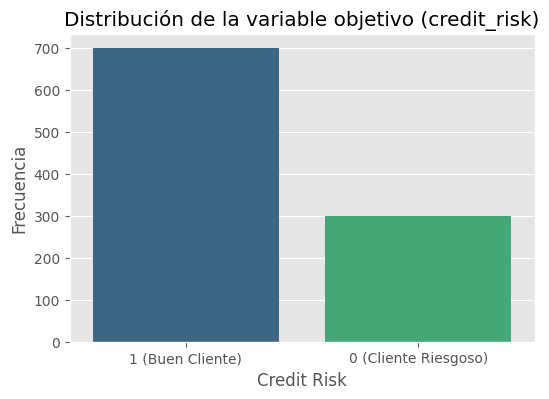

In [12]:
# Crear un mapeo de etiquetas
label_map = {0: "0 (Cliente Riesgoso)", 1: "1 (Buen Cliente)"}

plt.figure(figsize = (6, 4))
sns.countplot(
    x = "credit_risk",
    data = df.replace({"credit_risk": label_map}),
    palette = "viridis"
)

plt.title("Distribuci√≥n de la variable objetivo (credit_risk)")
plt.xlabel("Credit Risk")
plt.ylabel("Frecuencia")
plt.show()

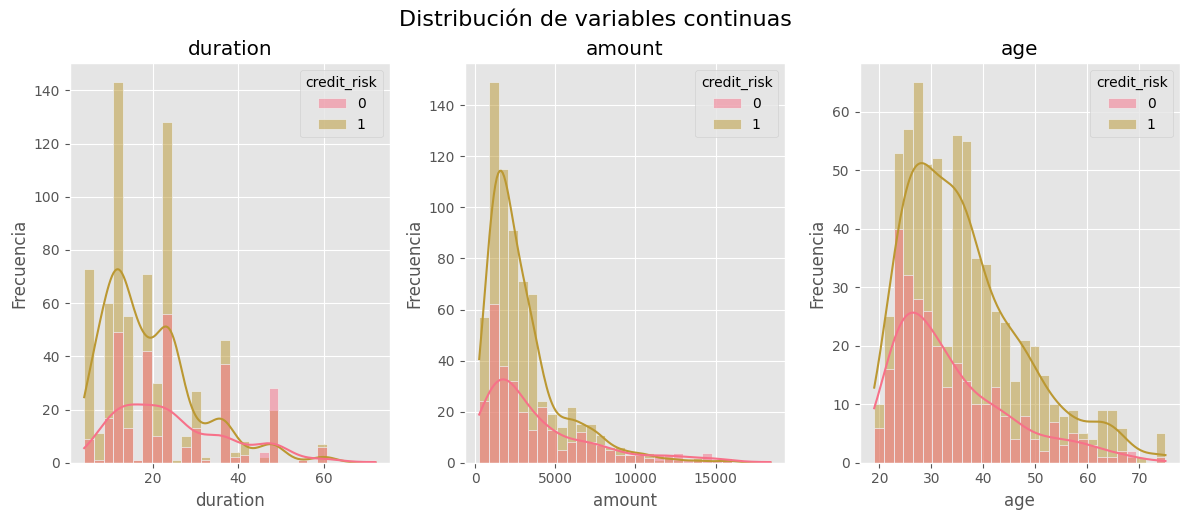

In [13]:
# Histograma para cada variable predictora num√©rica
plt.figure(figsize = (12, 5))
for i, col in enumerate(numeric_vars, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data = df, x = col, kde = True, bins = 30, color = 'skyblue', hue = 'credit_risk')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Distribuci√≥n de variables continuas", fontsize = 16, y = 1.03)
plt.show()

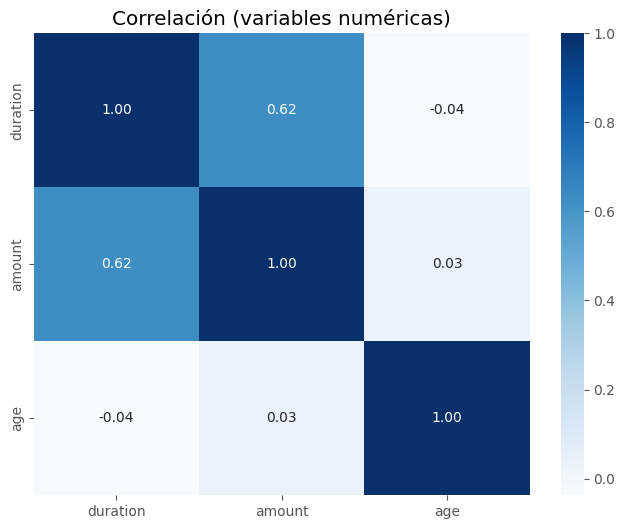

In [14]:
# Matriz de correlaci√≥n sobre num√©ricas
plt.figure(figsize = (8, 6))
sns.heatmap(df[numeric_vars].corr(), annot = True, cmap = "Blues", fmt = ".2f")
plt.title("Correlaci√≥n (variables num√©ricas)")
plt.show()

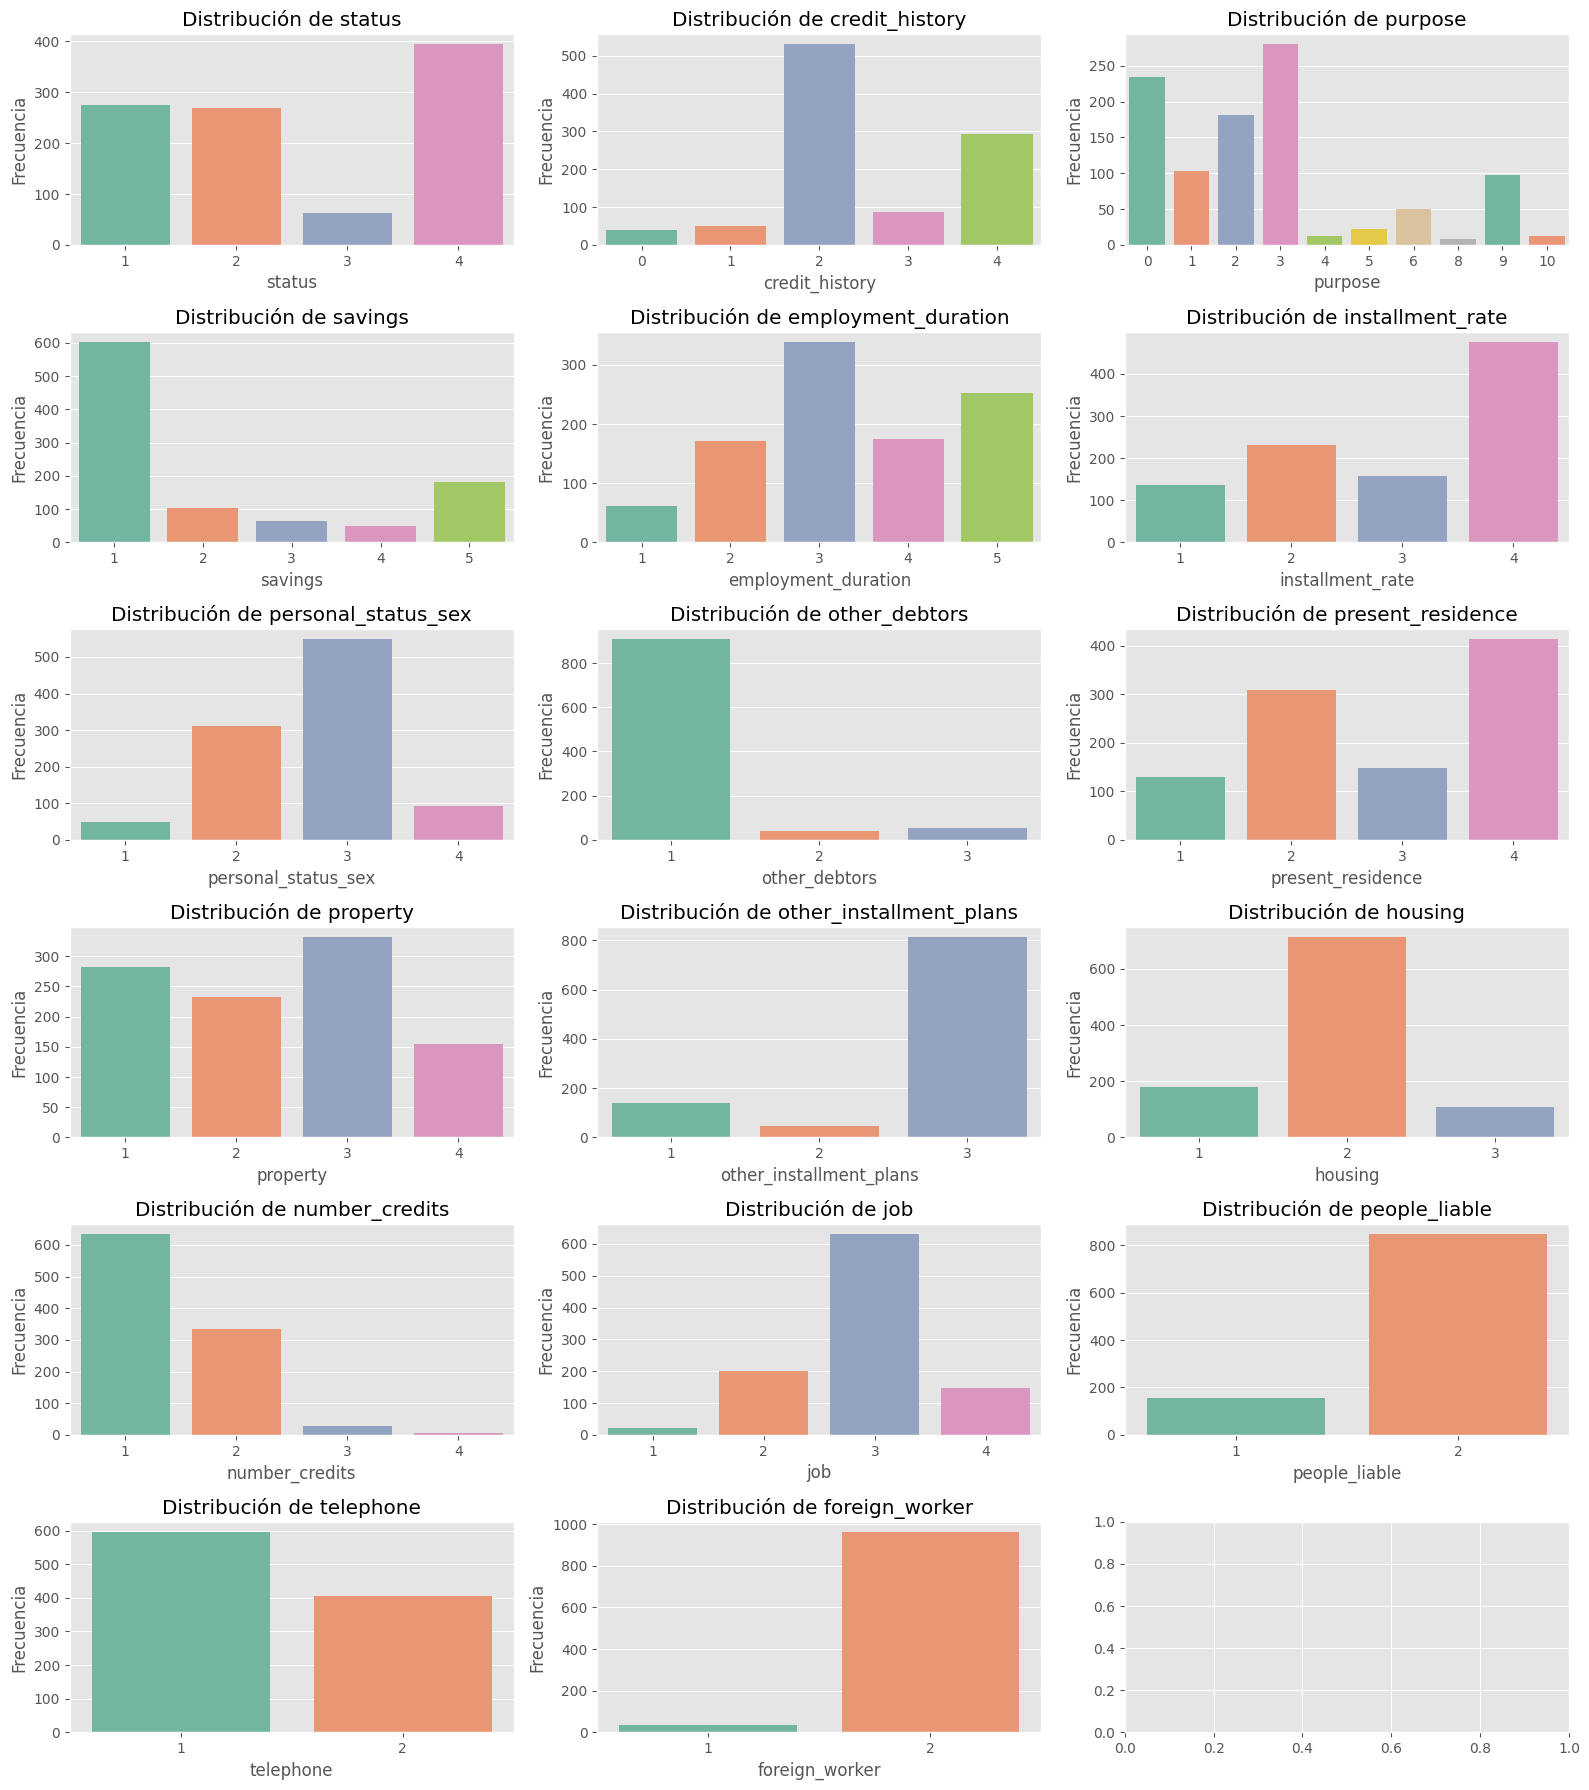

In [15]:
# Distribuci√≥n de variables categ√≥ricas
fig, axes = plt.subplots(len(categorical_vars)//3 + 1, 3, figsize = (16, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_vars):
    sns.countplot(x = col, data = df, ax = axes[i], palette = "Set2")
    axes[i].set_title(f"Distribuci√≥n de {col}")
    axes[i].set_ylabel("Frecuencia")

# Ajustar espacios
plt.tight_layout()
plt.show()

üìä **An√°lisis Exploratorio de Datos - German Credit Data**

**1. Distribuci√≥n de la variable objetivo (*credit_risk*)**

- La variable est√° **desbalanceada**: alrededor del **70% de los clientes son buenos pagadores (Buen Cliente)** y el **30% son clientes riesgosos**.
  
- Esto implica que, en modelos de predicci√≥n, ser√° necesario considerar t√©cnicas para manejar el desbalance (ejemplo: *class weights*, *SMOTE*, *undersampling*).  

---

**2. Variables num√©ricas**

- **Duraci√≥n del cr√©dito (duration):**  
  La mayor√≠a de los cr√©ditos tienen una duraci√≥n entre **12 y 24 meses**. Los clientes riesgosos tienden a solicitar cr√©ditos de mayor duraci√≥n.  

- **Monto del cr√©dito (amount):**  
  La distribuci√≥n es asim√©trica a la derecha, con muchos clientes solicitando montos bajos (~2000‚Äì4000). Los clientes riesgosos tienden a pedir cr√©ditos de mayor valor.  

- **Edad (age):**  
  La mayor√≠a de clientes est√°n entre los **20 y 40 a√±os**. Los clientes con mayor edad aparecen en menor proporci√≥n, pero se observa que los clientes riesgosos tienden a estar en edades m√°s j√≥venes.  

---

**3. Variables categ√≥ricas**

- **Historial de cr√©dito (credit_history):**  
  Un historial bueno o adecuado est√° asociado con clientes de menor riesgo. Los clientes con historial problem√°tico aparecen m√°s en la categor√≠a de alto riesgo.  

- **Prop√≥sito del cr√©dito (purpose):**  
  Los cr√©ditos para autom√≥vil y bienes de consumo son los m√°s frecuentes. En prop√≥sitos menos comunes (como educaci√≥n o vacaciones) se observa una mayor proporci√≥n de clientes riesgosos.  

- **Ahorros (savings) y duraci√≥n en empleo (employment_duration):**  
  Los clientes con mayores ahorros y mayor tiempo en el empleo suelen ser **menos riesgosos**, mientras que quienes reportan pocos o nulos ahorros tienden a ser clientes riesgosos.  

- **Estado civil y g√©nero (personal_status_sex):**  
  Se aprecian diferencias en la composici√≥n de riesgo seg√∫n grupo, aunque no es la variable con mayor poder discriminante.  

- **Vivienda (housing):**  
  La mayor√≠a de clientes viven en casas propias o alquiladas. No hay diferencias muy marcadas, aunque quienes viven en alquiler parecen tener un poco m√°s de riesgo.  

- **Otros garantes (other_debtors):**  
  La gran mayor√≠a de los clientes no tienen otros garantes. Quienes s√≠ los tienen presentan menor frecuencia y pueden asociarse a diferentes niveles de riesgo.  

- **N√∫mero de cr√©ditos (number_credits):**  
  La mayor√≠a tiene entre 1 y 2 cr√©ditos. A medida que aumenta el n√∫mero de cr√©ditos, aparece mayor riesgo.  

- **Tel√©fono y trabajador extranjero (telephone, foreign_worker):**  
  No muestran grandes diferencias entre clientes buenos y riesgosos, por lo que su poder predictivo puede ser limitado.  

---

‚úÖ **Conclusiones del an√°lisis exploratorio**

- El **dataset est√° desbalanceado** (m√°s buenos clientes que riesgosos).

- Los **clientes riesgosos** se asocian con:  
    - Cr√©ditos de **mayor duraci√≥n**.  
    - **Montos m√°s altos**.  
    - **Pocos ahorros y menor estabilidad laboral**.  
    - **Historial crediticio negativo**.

- Las variables num√©ricas muestran distribuciones asim√©tricas, por lo que podr√≠an requerir transformaciones (ejemplo: logaritmos en el monto).

- Varias variables categ√≥ricas (historial, ahorros, empleo) parecen tener **buen poder discriminante** para clasificar el riesgo.

#### <strong><font color="green">2. Preprocesamiento</font></strong>

In [16]:
# OBJETIVO DEL MODELO: probabilidad de IMPAGO (cliente riesgoso)
"""
Convierte la variable objetivo en binaria:
Resta el valor de la columna TARGET a 1 y lo convierte en entero (0 o 1).
Se usa para que la clase "buen cliente" quede como 0 y "riesgoso" como 1.
"""
y = (1 - df[TARGET].values).astype(int)             # y=1 => impago/riesgoso, y=0 => buen cliente
X = df[categorical_vars + numeric_vars].copy()      # Crea el conjunto de variables predictoras copiando solo las columnas categ√≥ricas y num√©ricas

In [17]:
# Split estratificado: train / val / test
TEST_SIZE = 0.15        # Proporci√≥n de datos destinada a prueba
VAL_SIZE = 0.15         # Proporci√≥n de datos destinada a validaci√≥n

# Proporci√≥n de datos destinada a prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,                          # Variables de entrada
    y,                          # Variable objetivo
    test_size = TEST_SIZE,      # Porcentaje destinado a prueba
    random_state = SEED,        # Semilla para reproducibilidad
    stratify = y                # Estratifica para mantener la proporci√≥n de clases
)

# Proporci√≥n de datos destinada a validaci√≥n
val_ratio = VAL_SIZE / (1 - TEST_SIZE)

# Divide el conjunto train_val en entrenamiento y validaci√≥n
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,                # Subconjunto de entrenamiento+validaci√≥n (entradas)
    y_train_val,                # Subconjunto de entrenamiento+validaci√≥n (etiquetas)
    test_size = val_ratio,      # Porcentaje destinado a validaci√≥n
    random_state = SEED,        # Semilla para reproducibilidad
    stratify = y_train_val      # Estratifica para mantener proporci√≥n de clases en validaci√≥n
)

In [18]:
# Ver distribuciones
print("üîπ Distribuci√≥n de clases para train - validation - test:\n")
print("Dist. clases (train):", pd.Series(y_train).value_counts(normalize = True).round(3).to_dict())
print("Dist. clases (val):  ", pd.Series(y_val).value_counts(normalize = True).round(3).to_dict())
print("Dist. clases (test): ", pd.Series(y_test).value_counts(normalize = True).round(3).to_dict())
print("\nüîπ Distribuci√≥n de clases (train, antes de SMOTE):")
display(pd.Series(y_train).value_counts().rename({0:"Bueno(0)",1:"Impago(1)"}))
print("üîπ Proporciones (train, antes de SMOTE):")
display(pd.Series(y_train).value_counts(normalize = True).round(3).rename({0:"Bueno(0)",1:"Impago(1)"}))

üîπ Distribuci√≥n de clases para train - validation - test:

Dist. clases (train): {0: 0.7, 1: 0.3}
Dist. clases (val):   {0: 0.7, 1: 0.3}
Dist. clases (test):  {0: 0.7, 1: 0.3}

üîπ Distribuci√≥n de clases (train, antes de SMOTE):


Bueno(0)     490
Impago(1)    210
Name: count, dtype: int64

üîπ Proporciones (train, antes de SMOTE):


Bueno(0)     0.7
Impago(1)    0.3
Name: proportion, dtype: float64

In [19]:
"""
Este bloque de c√≥digo define el preprocesamiento de datos para el modelo. Incluye la creaci√≥n
de pipelines para variables num√©ricas y categ√≥ricas, as√≠ como un ColumnTransformer que integra
ambos procesos en un √∫nico objeto de preprocesamiento.
"""

try:
    # Se intenta crear un codificador OneHotEncoder con el par√°metro 'sparse_output'
    ohe = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")
except TypeError:
    # Compatibilidad con versiones anteriores de sklearn, que usaban 'sparse' en lugar de 'sparse_output'
    ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")

# Pipeline para variables num√©ricas: imputaci√≥n de valores faltantes y escalado
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),    # Reemplaza valores faltantes por la mediana
    ("scaler", StandardScaler())                        # Normaliza valores num√©ricos con media 0 y varianza 1
])

# Pipeline para variables categ√≥ricas: imputaci√≥n de valores faltantes y codificaci√≥n one-hot
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),     # Reemplaza valores faltantes por la moda
    ("onehot", ohe)                                             # Convierte categor√≠as en variables binarias (dummy)
])

# ColumnTransformer: aplica el pipeline correspondiente a cada tipo de variable
preprocessor = ColumnTransformer(transformers = [
    ("num", numeric_pipeline, numeric_vars),            # Aplica pipeline num√©rico a variables num√©ricas
    ("cat", categorical_pipeline, categorical_vars)     # Aplica pipeline categ√≥rico a variables categ√≥ricas
])

In [20]:
# Ajustar en train y transformar todo
Xtr = preprocessor.fit_transform(X_train)       # Ajusta el preprocesador con los datos de entrenamiento y los transforma
Xv  = preprocessor.transform(X_val)             # Transforma los datos de validaci√≥n usando el preprocesador ya entrenado
Xte = preprocessor.transform(X_test)            # Transforma los datos de prueba usando el preprocesador ya entrenado

In [21]:
# Nombres de features resultantes (√∫til para interpretabilidad)
"""
Este bloque de c√≥digo obtiene los nombres de las variables resultantes despu√©s del preprocesamiento.
Primero intenta extraerlos directamente con `get_feature_names_out`. 
Si no funciona (por compatibilidad con versiones antiguas), los reconstruye manualmente 
considerando variables num√©ricas y las categor√≠as expandidas del OneHotEncoder.
Finalmente imprime la dimensi√≥n final de la matriz de caracter√≠sticas procesadas.
"""

try:
    # Intenta obtener directamente los nombres de todas las features procesadas
    feature_names = preprocessor.get_feature_names_out().tolist()
except Exception:
    # Fallback para versiones m√°s antiguas de sklearn
    feature_names = []
    feature_names.extend(numeric_vars)  # Agrega las variables num√©ricas
    
    # Obtiene el encoder categ√≥rico desde el preprocesador
    enc = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    
    # Expande cada variable categ√≥rica en m√∫ltiples columnas seg√∫n sus categor√≠as
    for i, col in enumerate(categorical_vars):
        cats = enc.categories_[i]
        feature_names += [f"{col}__{c}" for c in cats]

# Imprime la cantidad total de caracter√≠sticas resultantes tras el preprocesamiento
print("üîπ Dimensi√≥n final de features:", Xtr.shape[1])

üîπ Dimensi√≥n final de features: 71


In [22]:
# Manejo de desbalanceo
"""
Este bloque de c√≥digo aplica la t√©cnica SMOTE (Synthetic Minority Oversampling Technique) 
para balancear las clases en el conjunto de entrenamiento, generando ejemplos sint√©ticos 
de la clase minoritaria. Se ajusta din√°micamente el n√∫mero de vecinos `k_neighbors` 
para evitar errores cuando hay muy pocos casos en la clase minoritaria.
"""

# Calcula el n√∫mero m√≠nimo de muestras entre las clases en el conjunto de entrenamiento
min_count = pd.Series(y_train).value_counts().min()

# Define el n√∫mero de vecinos a usar en SMOTE (entre 1 y 5, pero sin superar min_count - 1)
k_neighbors = max(1, min(5, min_count - 1))

# Inicializa el objeto SMOTE con la semilla y el n√∫mero de vecinos definidos
sm = SMOTE(random_state = SEED, k_neighbors = k_neighbors)

# Aplica SMOTE al conjunto de entrenamiento (Xtr, y_train)
Xtr_bal, ytr_bal = sm.fit_resample(Xtr, y_train)

# Imprime la nueva dimensi√≥n tras aplicar SMOTE
print(f"SMOTE aplicado: {Xtr.shape} -> {Xtr_bal.shape} (k_neighbors = {k_neighbors})")

SMOTE aplicado: (700, 71) -> (980, 71) (k_neighbors = 5)


In [23]:
# Mostrar distribuci√≥n ANTES vs DESPU√âS de SMOTE
"""
Este bloque de c√≥digo compara la distribuci√≥n de clases en el conjunto de entrenamiento 
antes y despu√©s de aplicar SMOTE, mostrando los resultados en un DataFrame para mayor claridad.
"""

# Cuenta la cantidad de instancias de cada clase antes de SMOTE
dist_antes = pd.Series(y_train).value_counts().sort_index()

# Cuenta la cantidad de instancias de cada clase despu√©s de SMOTE
dist_despues = pd.Series(ytr_bal).value_counts().sort_index()

# Mensaje informativo
print("üîπ Distribuci√≥n de clases (train) antes y despu√©s de SMOTE:")

# Muestra la distribuci√≥n en un DataFrame con etiquetas descriptivas
display(pd.DataFrame({
    "Antes_SMOTE": dist_antes.rename(index = {0: "Bueno (0)", 1: "Impago (1)"}),
    "Despu√©s_SMOTE": dist_despues.rename(index = {0: "Bueno (0)", 1: "Impago (1)"})
}))

üîπ Distribuci√≥n de clases (train) antes y despu√©s de SMOTE:


Antes_SMOTE  Despu√©s_SMOTE
Bueno (0)           490            490
Impago (1)          210            490

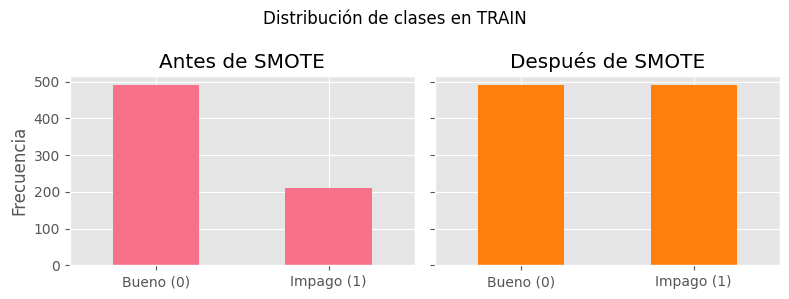

In [24]:
# Gr√°fico para visualizar distribuci√≥n de clases antes y despu√©s del balanceo
fig, axes = plt.subplots(1, 2, figsize = (8, 3), sharey = True)
dist_antes.plot(kind = "bar", ax = axes[0], title = "Antes de SMOTE")
axes[0].set_xticklabels(["Bueno (0)","Impago (1)"], rotation = 0)
axes[0].set_ylabel("Frecuencia")
dist_despues.plot(kind = "bar", ax = axes[1], title = "Despu√©s de SMOTE", color = "tab:orange")
axes[1].set_xticklabels(["Bueno (0)","Impago (1)"], rotation = 0)
plt.suptitle("Distribuci√≥n de clases en TRAIN")
plt.tight_layout()
plt.show()

#### <strong><font color="green">3. Construcci√≥n del modelo</font></strong>

In [25]:
INPUT_DIM = Xtr.shape[1]        # Dimensi√≥n de entrada (n√∫mero de caracter√≠sticas despu√©s del preprocesamiento)
LR = 1e-3                       # Tasa de aprendizaje inicial para el optimizador
L2 = 1e-4                       # Par√°metro de regularizaci√≥n L2 para evitar sobreajuste
DROPOUT = 0.2                   # Tasa de Dropout para reducir sobreajuste desactivando neuronas aleatoriamente
EPOCHS = 80                     # N√∫mero total de √©pocas de entrenamiento
BATCH_SIZE = 256                # Tama√±o de lote (n√∫mero de muestras procesadas antes de actualizar los pesos)
MONITOR = "val_auc"             # M√©trica a monitorear durante el entrenamiento (√°rea bajo la curva ROC en validaci√≥n)

In [26]:
# Modelo 1: DNN simple
"""
Este bloque de c√≥digo construye una red neuronal profunda (DNN simple) para clasificaci√≥n binaria.
La arquitectura incluye varias capas densas con activaci√≥n ReLU, regularizaci√≥n L2 y Dropout 
para reducir el sobreajuste. La salida usa activaci√≥n sigmoide para producir probabilidades.
"""

# Capa de entrada con dimensi√≥n igual al n√∫mero de features
inputs_dnn = keras.Input(shape = (INPUT_DIM,), name = "inputs_dnn")  

# Primera capa densa con 256 neuronas, activaci√≥n ReLU y regularizaci√≥n L2
x = layers.Dense(256, activation = "relu", kernel_regularizer = regularizers.l2(L2))(inputs_dnn)  

# Dropout para reducir sobreajuste
x = layers.Dropout(DROPOUT)(x)  

# Segunda capa densa con 128 neuronas, activaci√≥n ReLU y regularizaci√≥n L2
x = layers.Dense(128, activation = "relu", kernel_regularizer = regularizers.l2(L2))(x)  

# Dropout
x = layers.Dropout(DROPOUT)(x)

# Tercera capa densa con 64 neuronas, activaci√≥n ReLU y regularizaci√≥n L2
x = layers.Dense(64, activation = "relu", kernel_regularizer = regularizers.l2(L2))(x)  

# Dropout
x = layers.Dropout(DROPOUT)(x)  

# Capa de salida con 1 neurona y activaci√≥n sigmoide para clasificaci√≥n binaria
outputs_dnn = layers.Dense(1, activation = "sigmoid")(x)  

# Define el modelo completo conectando entradas y salidas
model_dnn = keras.Model(inputs_dnn, outputs_dnn, name = "DNN_simple")

In [27]:
# Compilar modelo DNN simple
model_dnn.compile(
    optimizer = keras.optimizers.Adam(LR),      # Optimizador Adam con la tasa de aprendizaje definida
    loss = "binary_crossentropy",               # Funci√≥n de p√©rdida para clasificaci√≥n binaria
    metrics = [
        keras.metrics.BinaryAccuracy(name = "accuracy"), # M√©trica de exactitud (predicciones correctas)
        keras.metrics.AUC(name = "auc"),                 # √Årea bajo la curva ROC
        keras.metrics.Precision(name = "precision"),     # Precisi√≥n (proporci√≥n de verdaderos positivos)
        keras.metrics.Recall(name = "recall"),           # Recall (proporci√≥n de positivos detectados)
    ],
)

# Mostrar la arquitectura del modelo
model_dnn.summary()

Model: "DNN_simple"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ inputs_dnn (InputLayer)         ‚îÇ (None, 71)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ        18,432 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 128)            ‚îÇ        32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 59,649 (233.00 KB)

 Trainable params: 59,649 (233.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Modelo 2: ResNet tabular
"""
Este bloque de c√≥digo define las primeras capas de una red neuronal tipo ResNet 
para datos tabulares. Se utiliza una capa densa inicial, seguida de normalizaci√≥n por lotes 
y activaci√≥n ReLU, con regularizaci√≥n L2 para reducir el sobreajuste.
"""

# Capa de entrada con dimensi√≥n igual al n√∫mero de caracter√≠sticas
inputs_res = keras.Input(shape = (INPUT_DIM,), name = "inputs_resnet")  

# Capa densa con 256 neuronas y regularizaci√≥n L2
z = layers.Dense(256, kernel_regularizer = regularizers.l2(L2))(inputs_res)  

# Normalizaci√≥n por lotes para estabilizar y acelerar el entrenamiento
z = layers.BatchNormalization()(z)  

# Activaci√≥n ReLU para introducir no linealidad
z = layers.Activation("relu")(z)  

In [29]:
# Bloques residuales (3 bloques)
"""
Este bloque de c√≥digo implementa bloques residuales (ResNet blocks) 
para una red neuronal aplicada a datos tabulares. 
Cada bloque tiene una rama principal y una conexi√≥n de atajo (shortcut) 
que permite el flujo de gradientes y ayuda a entrenar redes m√°s profundas.
"""

WIDTH = 256  # N√∫mero de neuronas en cada capa del bloque residual

for b in range(3):  # Construcci√≥n de 3 bloques residuales
    shortcut = z  # Se guarda la entrada original para la conexi√≥n residual
    
    # Rama principal
    # Primera capa densa con regularizaci√≥n L2
    h = layers.Dense(WIDTH, kernel_regularizer = regularizers.l2(L2))(z)
    h = layers.BatchNormalization()(h)       # Normalizaci√≥n por lotes
    h = layers.Activation("relu")(h)         # Activaci√≥n ReLU
    h = layers.Dropout(DROPOUT)(h)           # Dropout para evitar sobreajuste
    
    # Segunda capa densa con regularizaci√≥n L2
    h = layers.Dense(WIDTH, kernel_regularizer = regularizers.l2(L2))(h)
    h = layers.BatchNormalization()(h)       # Normalizaci√≥n por lotes
    
    # Rama de atajo (shortcut)
    # Ajusta la dimensi√≥n si no coincide con WIDTH
    if shortcut.shape[-1] != WIDTH:
        shortcut = layers.Dense(WIDTH, kernel_regularizer = regularizers.l2(L2))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Combina ramas
    z = layers.Add()([shortcut, h])   # Suma residual: salida = shortcut + rama principal
    z = layers.Activation("relu")(z)  # Activaci√≥n final del bloque

In [30]:
"""
Este bloque de c√≥digo define la capa de salida y construye el modelo completo tipo ResNet 
para clasificaci√≥n binaria en datos tabulares.
"""

# Capa de salida con 1 neurona y activaci√≥n sigmoide para obtener probabilidad entre 0 y 1
outputs_res = layers.Dense(1, activation = "sigmoid")(z)  

# Construcci√≥n del modelo ResNet conectando entradas y salidas
model_res = keras.Model(inputs_res, outputs_res, name = "ResNet_Tabular")

In [31]:
# Compilar el modelo ResNet tabular
model_res.compile(
    optimizer = keras.optimizers.Adam(LR),      # Optimizador Adam con la tasa de aprendizaje definida
    loss = "binary_crossentropy",               # Funci√≥n de p√©rdida para clasificaci√≥n binaria
    metrics = [
        keras.metrics.BinaryAccuracy(name = "accuracy"), # Exactitud en clasificaci√≥n
        keras.metrics.AUC(name = "auc"),                 # √Årea bajo la curva ROC
        keras.metrics.Precision(name = "precision"),     # Precisi√≥n: TP / (TP + FP)
        keras.metrics.Recall(name = "recall"),           # Recall: TP / (TP + FN)
    ],
)

# Mostrar la arquitectura del modelo
model_res.summary()

Model: "ResNet_Tabular"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ inputs_resnet       ‚îÇ (None, 71)        ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)     ‚îÇ (None, 256)       ‚îÇ     18,432 ‚îÇ inputs_resnet[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization ‚îÇ (None, 256)       ‚îÇ      1,024 ‚îÇ dense_4[0][0]     ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation          ‚îÇ (None, 256)       ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (Activation)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)     ‚îÇ (None, 256)       ‚îÇ     65,792 ‚îÇ activation[0][0]  ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 256)       ‚îÇ      1,024 ‚îÇ dense_5[0][0]     ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_1        ‚îÇ (None, 256)       ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (Activation)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout) ‚îÇ (None, 256)       ‚îÇ          0 ‚îÇ activation_1[0][‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)     ‚îÇ (None, 256)       ‚îÇ     65,792 ‚îÇ dropout_3[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 256)       ‚îÇ      1,024 ‚îÇ dense_6[0][0]     ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ       

 Total params: 420,609 (1.60 MB)

 Trainable params: 417,025 (1.59 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [32]:
# Callbacks
"""
Este bloque de c√≥digo define una lista de callbacks para mejorar el entrenamiento del modelo. 
Incluye EarlyStopping y ReduceLROnPlateau para evitar sobreajuste y optimizar el aprendizaje.
"""

CB = [
    callbacks.EarlyStopping(            # Detiene el entrenamiento si no hay mejora en la m√©trica monitoreada
        monitor = MONITOR,              # M√©trica a monitorear (ej. "val_auc")
        patience = 10,                  # N√∫mero de √©pocas de espera antes de detener el entrenamiento
        mode = "max",                   # Se busca maximizar la m√©trica
        restore_best_weights = True,    # Restaura los mejores pesos obtenidos
        verbose = 1                     # Muestra mensajes en consola
    ),
    callbacks.ReduceLROnPlateau(        # Reduce la tasa de aprendizaje cuando no hay mejora
        monitor = MONITOR,              # M√©trica a monitorear
        factor = 0.5,                   # Factor de reducci√≥n (nueva_lr = lr * factor)
        patience = 5,                   # N√∫mero de √©pocas de espera antes de reducir lr
        mode = "max",                   # Se busca maximizar la m√©trica
        verbose = 1                     # Muestra mensajes en consola
    ),
]

In [33]:
# Definir par√°metros para entrenamiento de modelos
"""
Este bloque de c√≥digo define los argumentos para entrenar el modelo 
utilizando Keras `model.fit()`. Incluye los datos de entrenamiento balanceados, 
validaci√≥n, n√∫mero de √©pocas, tama√±o de lote, callbacks y nivel de verbosidad.
"""

fit_args = dict(
    x = Xtr_bal,                        # Datos de entrenamiento balanceados (features)
    y = ytr_bal,                        # Etiquetas correspondientes al entrenamiento balanceado
    validation_data = (Xv, y_val),      # Datos de validaci√≥n (features y etiquetas)
    epochs = EPOCHS,                    # N√∫mero total de √©pocas de entrenamiento
    batch_size = BATCH_SIZE,            # Tama√±o de lote
    callbacks = CB,                     # Lista de callbacks (EarlyStopping, ReduceLROnPlateau, etc.)
    verbose = 2                         # Nivel de detalle en la salida (2 = una l√≠nea por √©poca)
)

In [34]:
# Entrenar modelo DNN simple
print("üöÄ Entrenando DNN simple (SMOTE)")
hist_dnn = model_dnn.fit(**fit_args)

üöÄ Entrenando DNN simple (SMOTE)
Epoch 1/80
4/4 - 2s - 403ms/step - accuracy: 0.4867 - auc: 0.4804 - loss: 0.7402 - precision: 0.4879 - recall: 0.5327 - val_accuracy: 0.7667 - val_auc: 0.6848 - val_loss: 0.6830 - val_precision: 0.7273 - val_recall: 0.3556 - learning_rate: 0.0010
Epoch 2/80
4/4 - 0s - 20ms/step - accuracy: 0.6153 - auc: 0.6833 - loss: 0.6973 - precision: 0.6647 - recall: 0.4653 - val_accuracy: 0.7467 - val_auc: 0.7485 - val_loss: 0.6609 - val_precision: 0.5814 - val_recall: 0.5556 - learning_rate: 0.0010
Epoch 3/80
4/4 - 0s - 20ms/step - accuracy: 0.6786 - auc: 0.7505 - loss: 0.6626 - precision: 0.6789 - recall: 0.6776 - val_accuracy: 0.7400 - val_auc: 0.7716 - val_loss: 0.6401 - val_precision: 0.5517 - val_recall: 0.7111 - learning_rate: 0.0010
Epoch 4/80
4/4 - 0s - 21ms/step - accuracy: 0.7357 - auc: 0.7936 - loss: 0.6225 - precision: 0.7167 - recall: 0.7796 - val_accuracy: 0.7667 - val_auc: 0.7869 - val_loss: 0.5964 - val_precision: 0.5893 - val_recall: 0.7333 - le

In [35]:
# Entrenar modelo ResNet Tabular
print("üöÄ Entrenando ResNet Tabular (SMOTE)")
hist_res = model_res.fit(**fit_args)

üöÄ Entrenando ResNet Tabular (SMOTE)
Epoch 1/80
4/4 - 4s - 885ms/step - accuracy: 0.6378 - auc: 0.6864 - loss: 0.9028 - precision: 0.6484 - recall: 0.6020 - val_accuracy: 0.6933 - val_auc: 0.7303 - val_loss: 0.8118 - val_precision: 0.4923 - val_recall: 0.7111 - learning_rate: 0.0010
Epoch 2/80
4/4 - 0s - 27ms/step - accuracy: 0.7980 - auc: 0.8892 - loss: 0.5894 - precision: 0.7704 - recall: 0.8490 - val_accuracy: 0.7467 - val_auc: 0.7594 - val_loss: 0.7585 - val_precision: 0.6296 - val_recall: 0.3778 - learning_rate: 0.0010
Epoch 3/80
4/4 - 0s - 26ms/step - accuracy: 0.8592 - auc: 0.9445 - loss: 0.4665 - precision: 0.8506 - recall: 0.8714 - val_accuracy: 0.7467 - val_auc: 0.7658 - val_loss: 0.7639 - val_precision: 0.5745 - val_recall: 0.6000 - learning_rate: 0.0010
Epoch 4/80
4/4 - 0s - 26ms/step - accuracy: 0.9020 - auc: 0.9693 - loss: 0.4005 - precision: 0.8988 - recall: 0.9061 - val_accuracy: 0.7533 - val_auc: 0.7744 - val_loss: 0.7531 - val_precision: 0.5870 - val_recall: 0.6000 

In [36]:
# Funci√≥n para Curvas de entrenamiento
def _plot_history(h, title):
    """
    Grafica la evoluci√≥n de las m√©tricas durante el entrenamiento de un modelo Keras.
    
    Par√°metros:
    - h (keras.callbacks.History): Objeto devuelto por model.fit() que contiene el historial.
    - title (str): T√≠tulo general para la figura.
    
    Retorna:
    - None: La funci√≥n muestra los gr√°ficos y no retorna valor.
    
    Efectos:
    - Muestra tres gr√°ficos en una misma figura:
        1. Accuracy (train vs val)
        2. AUC (train vs val)
        3. Loss (train vs val)
    """
    e = range(1, len(h.history["loss"]) + 1)        # Rango de √©pocas en el historial
    plt.figure(figsize = (16, 5))                   # Tama√±o de la figura

    # Subplot Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(e, h.history["accuracy"], label = "train")     # Accuracy en entrenamiento
    plt.plot(e, h.history["val_accuracy"], label = "val")   # Accuracy en validaci√≥n
    plt.title("Accuracy")
    plt.xlabel("√âpocas")
    plt.ylabel("Accuracy")
    plt.legend()

    # Subplot AUC
    plt.subplot(1, 3, 2)
    plt.plot(e, h.history["auc"], label = "train")          # AUC en entrenamiento
    plt.plot(e, h.history["val_auc"], label = "val")        # AUC en validaci√≥n
    plt.title("AUC")
    plt.xlabel("√âpocas")
    plt.ylabel("ROC-AUC")
    plt.legend()

    # Subplot Loss
    plt.subplot(1, 3, 3)
    plt.plot(e, h.history["loss"], label = "train")         # Loss en entrenamiento
    plt.plot(e, h.history["val_loss"], label = "val")       # Loss en validaci√≥n
    plt.title("Loss")
    plt.xlabel("√âpocas")
    plt.ylabel("Loss")
    plt.legend()

    plt.suptitle(title, fontsize = 16)      # T√≠tulo general de la figura
    plt.tight_layout()                      # Ajusta el espaciado
    plt.show()                              # Muestra los gr√°ficos

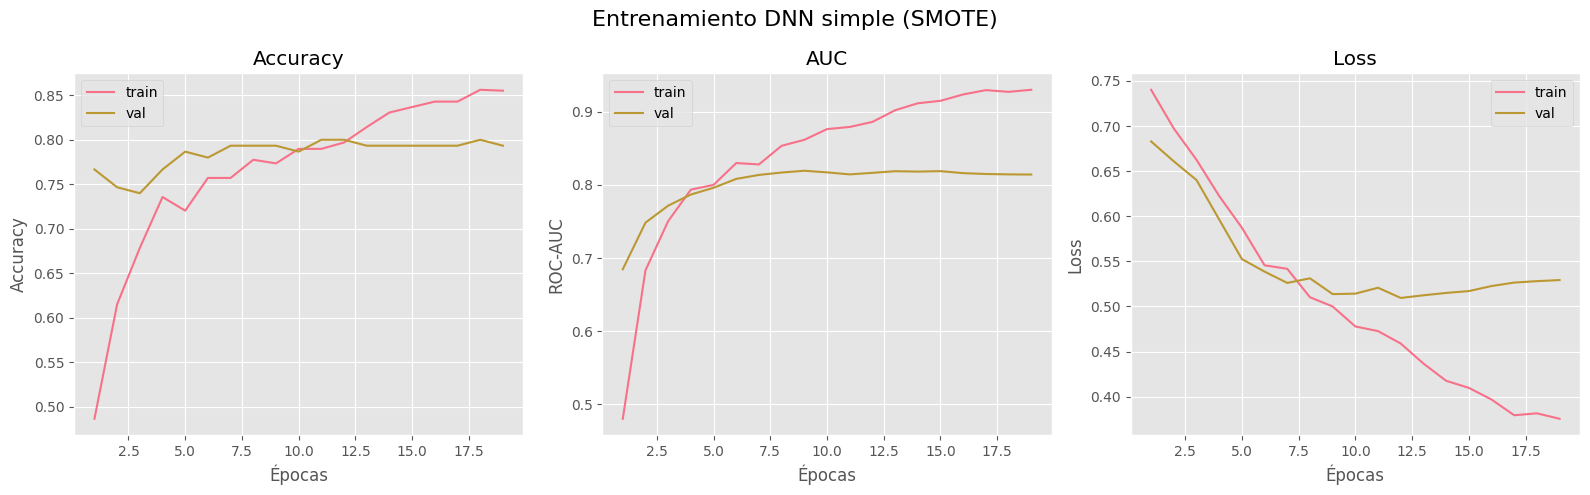

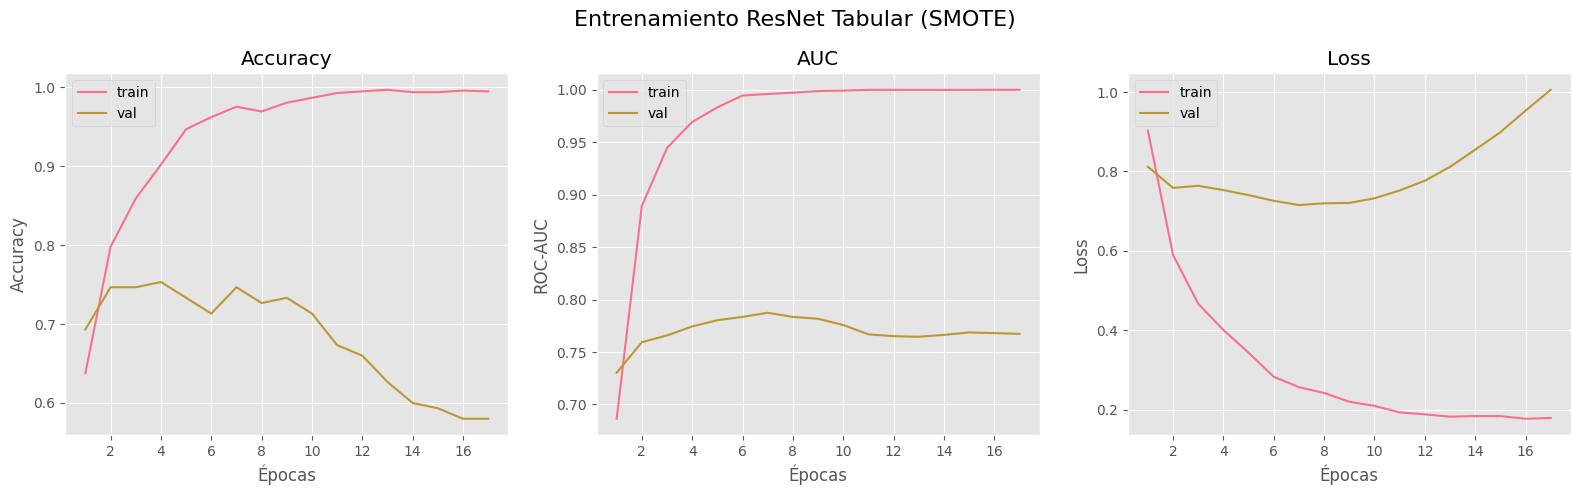

In [37]:
# Ver gr√°ficas de entrenamiento de modelos
_plot_history(hist_dnn, "Entrenamiento DNN simple (SMOTE)")
_plot_history(hist_res, "Entrenamiento ResNet Tabular (SMOTE)")

üìä **An√°lisis de entrenamiento: DNN simple vs ResNet Tabular (con SMOTE)**

üîπ **DNN simple**
- **Accuracy**  
  - Inicia en ~0.5 (nivel azar) y sube de forma estable.  
  - En validaci√≥n alcanza ~0.80 y se mantiene estable a partir de la √©poca 7‚Äì8.  
  - En entrenamiento llega a ~0.86, mostrando una **brecha moderada** con validaci√≥n (posible sobreajuste leve).  

- **AUC**  
  - En entrenamiento llega hasta ~0.93.  
  - En validaci√≥n se estabiliza en ~0.81, sin ca√≠das importantes ‚Üí buen nivel de generalizaci√≥n.  

- **Loss**  
  - Disminuye de forma estable en entrenamiento.  
  - En validaci√≥n baja hasta ~0.5 y luego se mantiene plana, sin divergencia fuerte.  

‚úÖ **Conclusi√≥n DNN**:  
- El modelo logra un buen equilibrio entre entrenamiento y validaci√≥n. Presenta un rendimiento estable con ligera tendencia a sobreajuste, pero en general es **robusto y confiable**.

---

üîπ **ResNet Tabular**
- **Accuracy**  
  - Crece muy r√°pido en entrenamiento y llega a **1.0 (perfecto)** en pocas √©pocas.  
  - En validaci√≥n se queda en ~0.70 y empieza a bajar ‚Üí clara se√±al de **sobreajuste fuerte**.  

- **AUC**  
  - En entrenamiento llega a casi 1.0.  
  - En validaci√≥n se estanca en ~0.76‚Äì0.78 y no mejora ‚Üí pobre capacidad de generalizaci√≥n.  

- **Loss**  
  - En entrenamiento disminuye de forma pronunciada.  
  - En validaci√≥n baja levemente al inicio, pero luego empieza a **subir**, confirmando el **overfitting**.  

‚ùå **Conclusi√≥n ResNet**:  
- La arquitectura ResNet es mucho m√°s potente y termina **sobreajustando r√°pidamente**. Aprende demasiado bien los patrones artificiales generados con SMOTE en entrenamiento, pero no logra transferir ese rendimiento al conjunto de validaci√≥n/test.

---

‚öñÔ∏è **Comparativa global**
- **DNN simple**  
  - Mejor equilibrio ‚Üí rendimiento m√°s estable y generalizable.  
  - AUC validaci√≥n ~0.81 (decente).  
  - Ligero sobreajuste, pero controlado.  

- **ResNet Tabular**  
  - Mucha capacidad de modelado, pero **sobreajusta fuerte**.  
  - AUC validaci√≥n solo ~0.76, pese a alcanzar casi 1.0 en entrenamiento.  
  - Requiere mayor regularizaci√≥n (Dropout m√°s alto, EarlyStopping m√°s estricto, o reducci√≥n de complejidad).  

---

‚úÖ **Recomendaci√≥n**:  
- Para este dataset, la **DNN simple es mejor opci√≥n en producci√≥n**, ya que ofrece un balance entre precisi√≥n y generalizaci√≥n.  
- La ResNet necesitar√≠a ajustes adicionales para evitar el sobreajuste (m√°s regularizaci√≥n, reducci√≥n de bloques o validaci√≥n cruzada).

#### <strong><font color="green">4. Explicabilidad</font></strong>

In [38]:
"""
Este bloque de c√≥digo aplica SHAP para interpretar el modelo seleccionado (DNN simple en este caso). 
Se define una funci√≥n de predicci√≥n, se selecciona un conjunto de fondo mediante KMeans, 
se eligen muestras de prueba y se calculan los valores SHAP con KernelExplainer.
"""

# Selecci√≥n del modelo a explicar (DNN simple)
best_model = model_dnn

# Funci√≥n de predicci√≥n que devuelve probabilidades planas (ravel)
f = lambda data: best_model.predict(data, verbose = 0).ravel()  

# Selecciona 50 centroides mediante KMeans como conjunto de fondo para SHAP
X_bg = shap.kmeans(Xtr, 50)  

# Inicializa el generador aleatorio con la semilla definida
rng = np.random.default_rng(SEED)

# Selecciona √≠ndices aleatorios del conjunto de prueba (sample) hasta 200 muestras
sm_idx = rng.choice(Xte.shape[0], size = min(200, Xte.shape[0]), replace = False)

# Subconjunto de prueba usado como muestra para SHAP
X_sm = Xte[sm_idx]

# Se crea el explicador SHAP usando KernelExplainer con la funci√≥n de predicci√≥n y el conjunto de fondo
explainer = shap.KernelExplainer(f, X_bg)  

# Calcula los valores SHAP sobre el conjunto de muestra, usando n√∫mero autom√°tico de muestras
shap_values = explainer.shap_values(X_sm, nsamples = "auto")  

# Si los valores SHAP vienen en una lista (ej. en clasificaci√≥n multiclase), se extrae el primer elemento
if isinstance(shap_values, list):
    shap_values = shap_values[0]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 150/150 [05:24<00:00,  2.17s/it]


üîπ Importancia global (features codificadas):


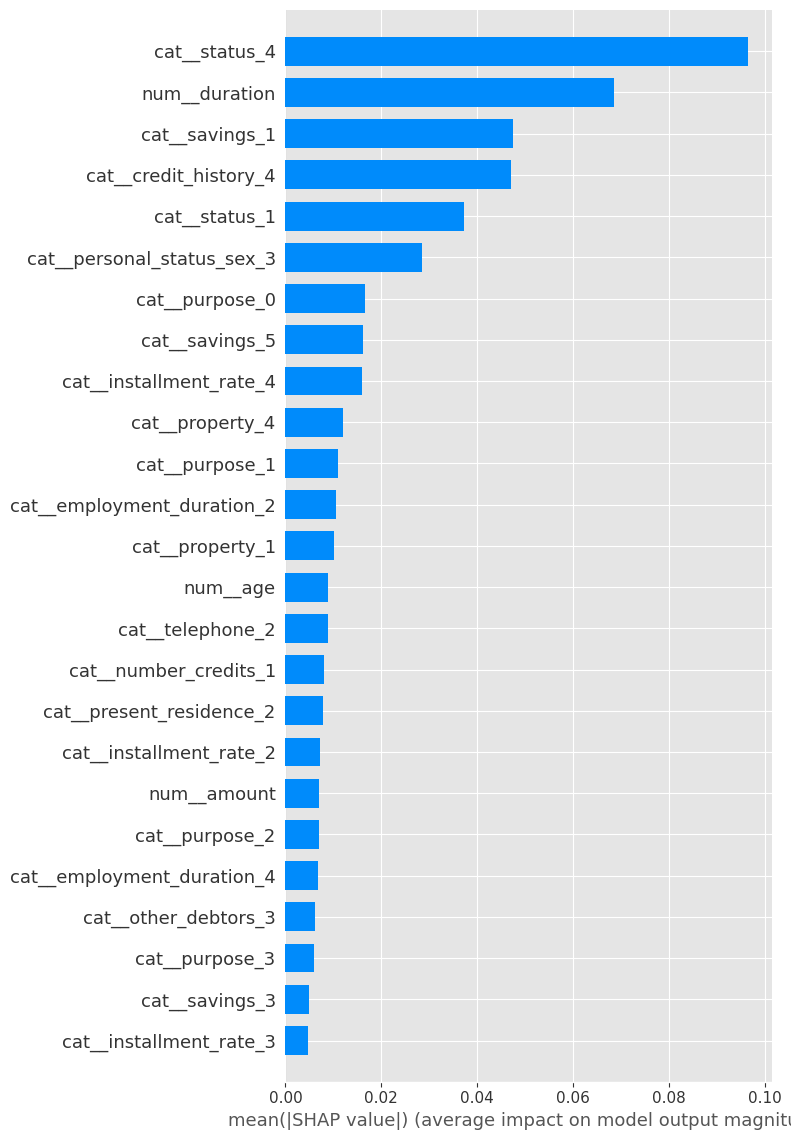

In [39]:
"""
Este bloque de c√≥digo muestra la importancia global de las variables (features) 
utilizando un gr√°fico resumen de SHAP. 
Se visualizan las 25 caracter√≠sticas m√°s relevantes en forma de barras.
"""

# Mensaje informativo en consola
print("üîπ Importancia global (features codificadas):")

# Genera un gr√°fico resumen de SHAP con las variables m√°s importantes
shap.summary_plot(
    shap_values,                        # Valores SHAP calculados para las muestras
    X_sm,                               # Subconjunto de datos usado para la explicaci√≥n
    feature_names = feature_names,      # Nombres de las caracter√≠sticas codificadas
    plot_type = "bar",                  # Tipo de gr√°fico (barras para importancia global)
    max_display = 25,                   # N√∫mero m√°ximo de caracter√≠sticas a mostrar
    show = True                         # Mostrar el gr√°fico inmediatamente
)

üîπ Beeswarm:


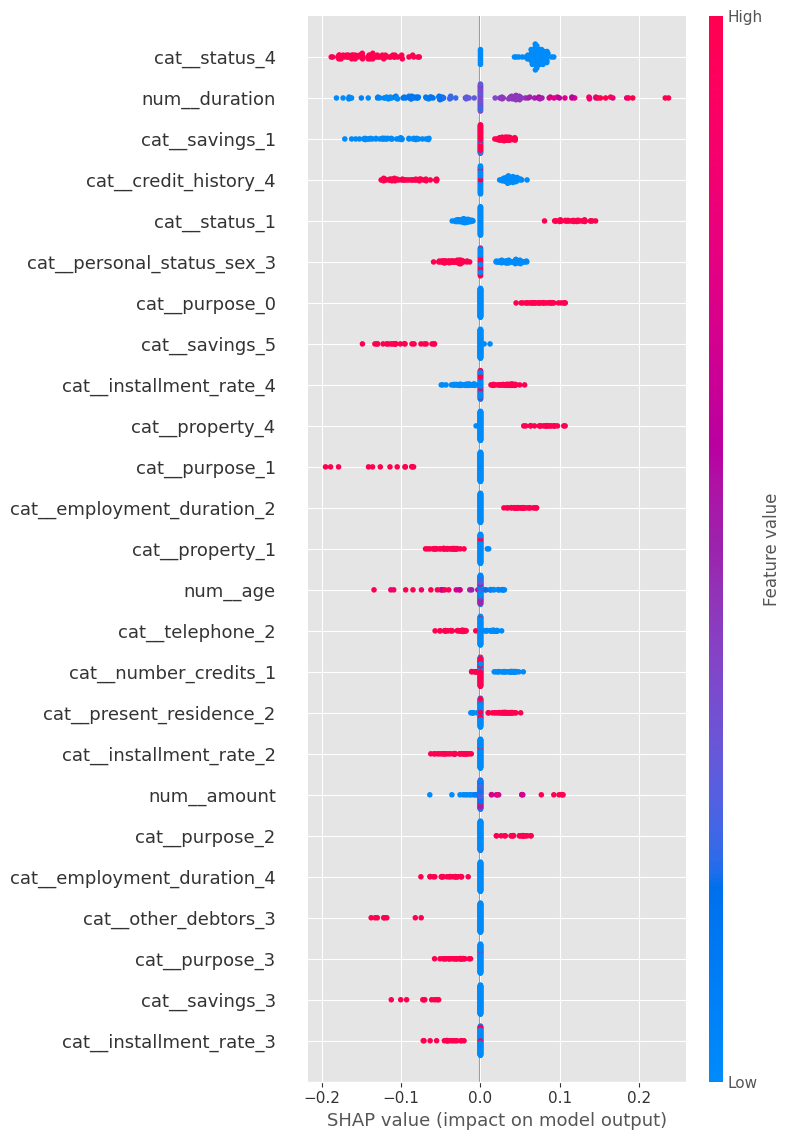

In [40]:
"""
Este bloque de c√≥digo genera un gr√°fico tipo "Beeswarm" con SHAP, 
el cual muestra la distribuci√≥n de los valores SHAP para cada variable, 
permitiendo observar tanto la importancia como la direcci√≥n del impacto 
positivo o negativo en las predicciones.
"""

# Mensaje informativo en consola
print("üîπ Beeswarm:")

# Genera el gr√°fico beeswarm de SHAP
shap.summary_plot(
    shap_values,                        # Valores SHAP calculados para las muestras
    X_sm,                               # Subconjunto de datos usado para la explicaci√≥n
    feature_names = feature_names,      # Nombres de las caracter√≠sticas codificadas
    max_display = 25,                   # N√∫mero m√°ximo de caracter√≠sticas a mostrar
    show = True                         # Mostrar el gr√°fico inmediatamente
)

In [41]:
# Agregaci√≥n por variable original (suma |SHAP| de dummies)
"""
Este bloque de c√≥digo calcula la importancia agregada de las variables originales 
(sumando la importancia de sus categor√≠as en caso de variables categ√≥ricas) 
y muestra las 20 variables m√°s relevantes en una tabla.
"""

# Obtiene el OneHotEncoder del preprocesador
enc = preprocessor.named_transformers_["cat"].named_steps["onehot"]

# Calcula la media de los valores absolutos SHAP para cada caracter√≠stica codificada
mean_abs_shap = np.mean(np.abs(shap_values), axis = 0)

# Diccionario para agrupar los √≠ndices de cada variable original (num√©ricas y categ√≥ricas)
groups = {c: [] for c in numeric_vars + categorical_vars}
idx = 0

# Variables num√©ricas (relaci√≥n 1 a 1)
for c in numeric_vars:
    groups[c].append(idx)  # Cada variable num√©rica ocupa una sola columna
    idx += 1

# Variables categ√≥ricas (expandida por OneHot)
for i, c in enumerate(categorical_vars):
    n_dum = len(enc.categories_[i])                # N√∫mero de categor√≠as creadas
    groups[c].extend(list(range(idx, idx + n_dum))) # Asigna √≠ndices correspondientes
    idx += n_dum

# Agregar importancia SHAP
rows = []
for col, inds in groups.items():
    # Suma la importancia de todas las columnas correspondientes a la misma variable original
    rows.append((col, float(np.sum(mean_abs_shap[inds]))))

# Crea un DataFrame con las importancias agregadas y las ordena
imp_agg = pd.DataFrame(rows, columns = ["feature", "mean_abs_shap_agg"]).sort_values("mean_abs_shap_agg", ascending = False)

# Mensaje informativo en consola
print("üîπ Importancia agregada de las variables originales:")

# Muestra las 20 variables m√°s importantes seg√∫n SHAP
imp_agg.head(20)

üîπ Importancia agregada de las variables originales:


feature  mean_abs_shap_agg
3                    status           0.138561
6                   savings           0.072023
0                  duration           0.068547
4            credit_history           0.051655
5                   purpose           0.047846
9       personal_status_sex           0.033347
8          installment_rate           0.028659
12                 property           0.023822
7       employment_duration           0.019028
11        present_residence           0.012401
10            other_debtors           0.010477
2                       age           0.008906
18                telephone           0.008906
15           number_credits           0.008017
1                    amount           0.007073
17            people_liable           0.003065
14                  housing           0.001919
19           foreign_worker           0.001534
13  other_installment_plans           0.001498
16                      job           0.000123

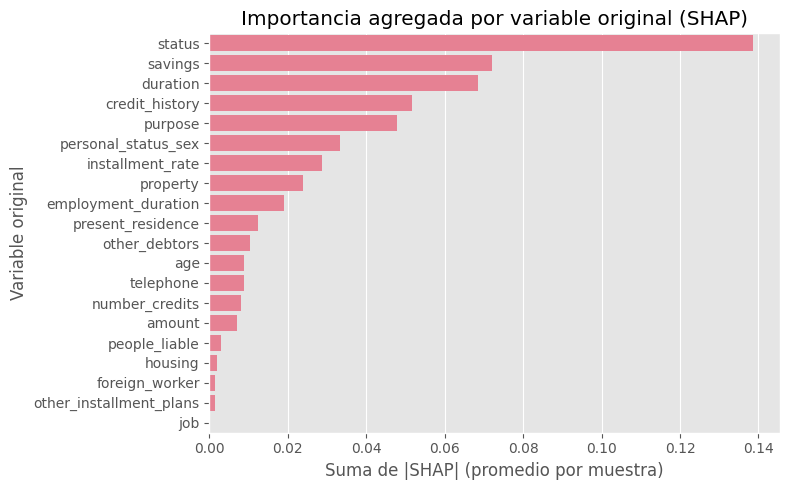

In [42]:
# Ver gr√°fico de importancia de variables
plt.figure(figsize = (8, 5))
sns.barplot(data = imp_agg.head(20), x = "mean_abs_shap_agg", y = "feature", orient = "h")
plt.title("Importancia agregada por variable original (SHAP)")
plt.xlabel("Suma de |SHAP| (promedio por muestra)")
plt.ylabel("Variable original")
plt.tight_layout()
plt.show()

üìå **Explicabilidad del modelo (SHAP) y contexto bancario**

Los gr√°ficos y tablas de SHAP permiten identificar qu√© variables influyen m√°s en la predicci√≥n de impago (1) o buen cliente (0).

---

üîπ **Variables m√°s influyentes**
Seg√∫n los gr√°ficos de importancia global y la agregaci√≥n por variable original, las variables m√°s determinantes son:

1. **Status (estado de cuenta previo al cr√©dito)**  
   - Es la variable m√°s influyente. Ciertos estados (ej. `cat_status_4`) elevan fuertemente la probabilidad de impago.  
   - Esto tiene sentido: la situaci√≥n crediticia previa refleja directamente el riesgo de incumplimiento.

2. **Savings (nivel de ahorros)**  
   - Un nivel bajo de ahorros incrementa el riesgo de impago.  
   - Clientes con mayores ahorros ofrecen m√°s seguridad al banco, ya que poseen un colch√≥n financiero.

3. **Duration (duraci√≥n del cr√©dito en meses)**  
   - Cr√©ditos m√°s largos tienden a asociarse con mayor riesgo.  
   - En pr√©stamos extensos, aumentan las probabilidades de que el cliente atraviese dificultades econ√≥micas durante el periodo.

4. **Credit history (historial de cr√©dito)**  
   - Historial negativo (morosidades previas, retrasos) incrementa el riesgo.  
   - Un historial s√≥lido disminuye la probabilidad de impago.

5. **Purpose (prop√≥sito del cr√©dito)**  
   - Algunos fines (ej. consumo, bienes no esenciales) muestran mayor riesgo en comparaci√≥n con prop√≥sitos m√°s estables (ej. vivienda).

6. **Personal status & sex**  
   - La combinaci√≥n de estado civil y sexo aparece como variable explicativa, aunque debe analizarse con cuidado para evitar sesgos indebidos en decisiones de cr√©dito.

---

 üîπ **Interpretaci√≥n de los gr√°ficos SHAP**
- **Summary barplot (importancia global codificada)**  
  Muestra el ranking de variables m√°s relevantes. El `status` y la `duration` tienen el mayor impacto promedio sobre las predicciones.

- **Beeswarm plot**  
  Permite ver la direcci√≥n de la influencia:  
  - Valores altos de `duration` (rojo) tienden a desplazar los SHAP values hacia el lado positivo (mayor riesgo).  
  - Ciertas categor√≠as de `status` generan fuertes impactos positivos en la predicci√≥n de impago.  
  - Para variables como `savings`, valores bajos (azul) est√°n asociados a un aumento del riesgo.

- **Agregaci√≥n por variable original**  
  Confirma que las 5 variables m√°s importantes son: `status`, `savings`, `duration`, `credit_history` y `purpose`.

---

üîπ **Implicancias en contexto bancario**
- **Variables financieras cl√°sicas (status, savings, duration, credit_history)** tienen un peso crucial y validan que el modelo est√© alineado con criterios tradicionales de evaluaci√≥n de riesgo.  
- **Variables socio-demogr√°ficas (personal_status_sex)**, aunque explicativas, deben tratarse con cautela para no incurrir en **discriminaci√≥n o sesgos**.  
- **Prop√≥sito del cr√©dito** permite entender qu√© tipos de pr√©stamos representan mayor exposici√≥n para el banco, lo que puede ayudar a ajustar pol√≠ticas internas.  
- El uso de SHAP asegura **transparencia y explicabilidad**, requisito clave en entornos regulados: se puede justificar por qu√© se aprueba o rechaza un cr√©dito.  
- Desde la perspectiva de negocio:  
  - Identificar que un cliente con mal historial y bajo nivel de ahorros tiene alta probabilidad de impago permite dise√±ar **estrategias de mitigaci√≥n** (ej. garant√≠as, tasas ajustadas, l√≠mites de monto).  
  - A la vez, da confianza de que el modelo no es una "caja negra" y que las decisiones pueden auditarse.

---

‚úÖ **Conclusi√≥n**:  
- El modelo basa sus predicciones en factores l√≥gicos y coherentes con la pr√°ctica crediticia. Variables como `status`, `savings`, `duration` y `credit_history` son las m√°s determinantes.  
Esto asegura que el sistema de scoring no solo es preciso, sino tambi√©n **interpretativo y justificable** en un contexto bancario, lo cual es esencial para cumplir con criterios de transparencia, regulaci√≥n y equidad.

#### <strong><font color="green">5. Evaluaci√≥n</font></strong>


##### <strong><font color="DarkSeaGreen">üî∏M√©tricas: precisi√≥n, recall, F1-score, curva ROC.</font></strong>

In [43]:
# Funci√≥n para calcular m√©tricas dado umbral de decisi√≥n
def metrics_at_threshold(y_true, y_prob, thr: float):
    """
    Calcula m√©tricas de clasificaci√≥n binaria dado un umbral de decisi√≥n.

    Par√°metros:
    - y_true (array-like): Etiquetas reales (0 o 1).
    - y_prob (array-like): Probabilidades predichas para la clase positiva.
    - thr (float): Umbral de decisi√≥n para clasificar como positivo.

    Retorna:
    - dict: Diccionario con las m√©tricas:
        - "thr": Umbral usado.
        - "accuracy": Exactitud.
        - "precision": Precisi√≥n.
        - "recall": Recall.
        - "f1": F1-score.
        - "auc": √Årea bajo la curva ROC (AUC).
        - "cm": Matriz de confusi√≥n (2x2).
    
    Efectos:
    - Calcula m√©tricas de rendimiento al aplicar un umbral espec√≠fico sobre las probabilidades.
    """
    # Aplica el umbral para convertir probabilidades en clases predichas
    y_pred = (y_prob >= thr).astype(int)
    
    # Calcula la matriz de confusi√≥n
    cm = confusion_matrix(y_true, y_pred)
    
    # Retorna las m√©tricas en un diccionario
    return {
        "thr": thr,                                                         # Umbral usado
        "accuracy": accuracy_score(y_true, y_pred),                         # Exactitud
        "precision": precision_score(y_true, y_pred, zero_division = 0),    # Precisi√≥n
        "recall": recall_score(y_true, y_pred, zero_division = 0),          # Recall
        "f1": f1_score(y_true, y_pred, zero_division = 0),                  # F1-score
        "auc": roc_auc_score(y_true, y_prob),                               # AUC-ROC
        "cm": cm                                                            # Matriz de confusi√≥n
    }

In [44]:
# Funci√≥n para graficar matriz de confusi√≥n
def plot_cm(cm, title):
    """
    Grafica una matriz de confusi√≥n como mapa de calor.

    Par√°metros:
    - cm (ndarray): Matriz de confusi√≥n (valores enteros).
    - title (str): T√≠tulo del gr√°fico.

    Retorna:
    - None: La funci√≥n muestra el gr√°fico y no retorna valor.

    Efectos:
    - Visualiza la matriz de confusi√≥n con etiquetas fijas para clases "Bueno" e "Impago".
    - A√±ade anotaciones de conteos en cada celda.
    """
    plt.figure(figsize = (4, 4))  # Tama√±o de la figura
    sns.heatmap(
        cm,
        annot = True, fmt = "d", cmap = "Blues", cbar = False,      # Muestra valores enteros sin barra lateral
        xticklabels = ["Pred 0: Bueno", "Pred 1: Impago"],          # Etiquetas eje X
        yticklabels = ["Real 0: Bueno", "Real 1: Impago"]           # Etiquetas eje Y
    )
    plt.title(title)            # T√≠tulo del gr√°fico
    plt.xlabel("Predicci√≥n")    # Etiqueta eje X
    plt.ylabel("Real")          # Etiqueta eje Y
    plt.tight_layout()          # Ajusta espaciado
    plt.show()                  # Muestra la figura

In [45]:
# Probabilidades en validaci√≥n (para buscar umbrales) y test
val_prob_dnn = model_dnn.predict(Xv, verbose = 0).ravel()
val_prob_res = model_res.predict(Xv, verbose = 0).ravel()
test_prob_dnn = model_dnn.predict(Xte, verbose = 0).ravel()
test_prob_res = model_res.predict(Xte, verbose = 0).ravel()

In [46]:
# Umbral que maximiza F1 (en validaci√≥n)
"""
Este bloque de c√≥digo busca el umbral de decisi√≥n √≥ptimo (threshold) para los modelos DNN y ResNet, 
maximizando la m√©trica F1 en el conjunto de validaci√≥n. 
Se eval√∫an distintos valores de umbral entre 0.05 y 0.95 y se selecciona el mejor.
"""

# Lista de posibles umbrales entre 0.05 y 0.95 en pasos de 0.05
candidatos = np.linspace(0.05, 0.95, 19)

# B√∫squeda del mejor umbral para el modelo DNN
best_dnn = None
for t in candidatos:
    m = metrics_at_threshold(y_val, val_prob_dnn, t)  # Calcula m√©tricas para el umbral t
    if (best_dnn is None) or (m["f1"] > best_dnn["f1"]):  # Actualiza si mejora el F1
        best_dnn = m

# B√∫squeda del mejor umbral para el modelo ResNet
best_res = None
for t in candidatos:
    m = metrics_at_threshold(y_val, val_prob_res, t)  # Calcula m√©tricas para el umbral t
    if (best_res is None) or (m["f1"] > best_res["f1"]):  # Actualiza si mejora el F1
        best_res = m

# Resultados
print(f"üîπ Umbral F1* DNN: {best_dnn['thr']:.2f} | F1(val) = {best_dnn['f1']:.3f}")
print(f"üîπ Umbral F1* Res: {best_res['thr']:.2f} | F1(val) = {best_res['f1']:.3f}")

üîπ Umbral F1* DNN: 0.40 | F1(val) = 0.680
üîπ Umbral F1* Res: 0.50 | F1(val) = 0.612


In [47]:
# Evaluaci√≥n en test @0.5 y @F1*
eval_dnn_05 = metrics_at_threshold(y_test, test_prob_dnn, 0.5)
eval_res_05 = metrics_at_threshold(y_test, test_prob_res, 0.5)
eval_dnn_bf = metrics_at_threshold(y_test, test_prob_dnn, best_dnn["thr"])
eval_res_bf = metrics_at_threshold(y_test, test_prob_res, best_res["thr"])

üîπ [DNN @0.5] {'thr': 0.5, 'accuracy': 0.707, 'precision': 0.509, 'recall': 0.622, 'f1': 0.56, 'auc': 0.77}


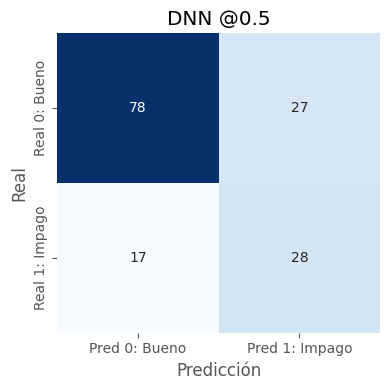


üîπ [DNN @best-F1] {'thr': 0.4, 'accuracy': 0.66, 'precision': 0.456, 'recall': 0.689, 'f1': 0.549, 'auc': 0.77}


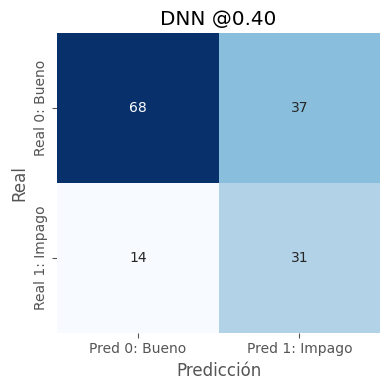

In [48]:
# Ver evaluaciones para DNN
print("üîπ [DNN @0.5]", {k: round(v,3) for k,v in eval_dnn_05.items() if k!='cm'})
plot_cm(eval_dnn_05["cm"], "DNN @0.5")
print("\nüîπ [DNN @best-F1]", {k: round(v,3) for k,v in eval_dnn_bf.items() if k!='cm'})
plot_cm(eval_dnn_bf["cm"], f"DNN @{eval_dnn_bf['thr']:.2f}")

üîπ [ResNet @0.5] {'thr': 0.5, 'accuracy': 0.72, 'precision': 0.525, 'recall': 0.711, 'f1': 0.604, 'auc': 0.767}


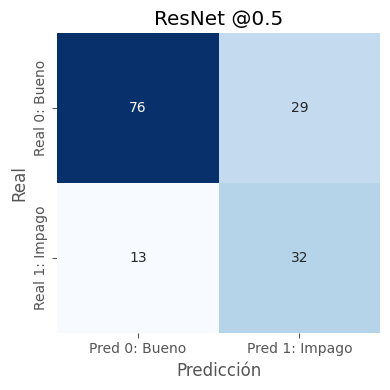


üîπ [ResNet @best-F1] {'thr': 0.5, 'accuracy': 0.72, 'precision': 0.525, 'recall': 0.711, 'f1': 0.604, 'auc': 0.767}


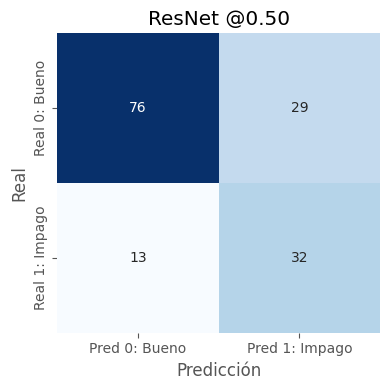

In [49]:
# Ver evaluaciones para ResNet
print("üîπ [ResNet @0.5]", {k: round(v,3) for k,v in eval_res_05.items() if k!='cm'})
plot_cm(eval_res_05["cm"], "ResNet @0.5")
print("\nüîπ [ResNet @best-F1]", {k: round(v,3) for k,v in eval_res_bf.items() if k!='cm'})
plot_cm(eval_res_bf["cm"], f"ResNet @{eval_res_bf['thr']:.2f}")

In [50]:
# Funci√≥n para Curvas ROC
def plot_roc(y_true, y_prob, title):
    """
    Grafica la curva ROC (Receiver Operating Characteristic) y muestra el AUC.
    
    Par√°metros:
    - y_true (array-like): Etiquetas reales (0 o 1).
    - y_prob (array-like): Probabilidades predichas para la clase positiva.
    - title (str): T√≠tulo del gr√°fico.
    
    Retorna:
    - None: La funci√≥n muestra el gr√°fico y no retorna valor.
    
    Efectos:
    - Calcula la curva ROC y el AUC.
    - Muestra la curva ROC con l√≠nea diagonal de referencia.
    """
    # Calcula tasa de falsos positivos (FPR), verdaderos positivos (TPR) y umbrales
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    
    # Calcula √°rea bajo la curva
    auc = roc_auc_score(y_true, y_prob)

    plt.figure(figsize = (5, 4))                   # Tama√±o de la figura
    plt.plot(fpr, tpr, label = f"AUC = {auc:.3f}")   # Curva ROC
    plt.plot([0, 1], [0, 1], "--")               # L√≠nea diagonal de referencia
    plt.xlabel("FPR")                            # Eje X: tasa de falsos positivos
    plt.ylabel("TPR")                            # Eje Y: tasa de verdaderos positivos
    plt.title(title)                             # T√≠tulo del gr√°fico
    plt.legend()                                 # Leyenda
    plt.tight_layout()                           # Ajusta espaciado
    plt.show()                                   # Muestra la figura

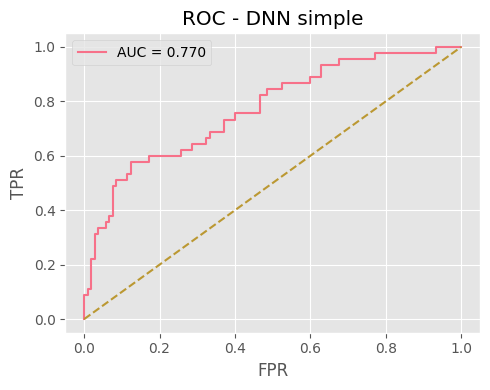

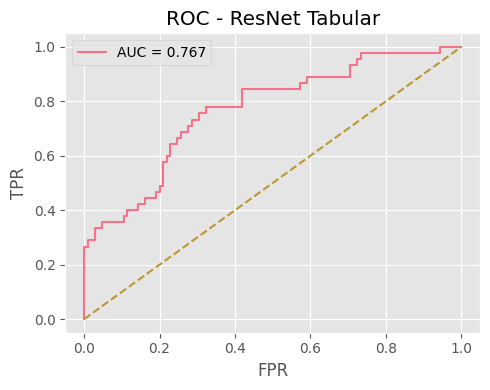

In [51]:
# Ver curvas ROC
plot_roc(y_test, test_prob_dnn, "ROC - DNN simple")
plot_roc(y_test, test_prob_res, "ROC - ResNet Tabular")

##### <strong><font color="DarkSeaGreen">üî∏An√°lisis del impacto de errores tipo I y II en contexto financiero.</font></strong>

In [52]:
# An√°lisis de costos (Tipo I y II)
"""
Este bloque de c√≥digo define los costos asociados a los errores de clasificaci√≥n 
en el contexto financiero (cr√©dito). Se diferencian los costos de errores tipo I (FP) 
y tipo II (FN), siendo estos √∫ltimos m√°s graves debido a las p√©rdidas monetarias 
por no detectar clientes que no pagar√°n.

- Positivo = impago (1)
- Tipo I (FP): predecir impago a alguien que es buen cliente (rechazo injustificado)
- Tipo II (FN): predecir bueno a quien impaga (p√©rdida econ√≥mica mayor)
"""

COST_FP = 1.0   # Costo relativo por clasificar err√≥neamente a un buen cliente como riesgoso
COST_FN = 10.0  # Costo relativo por clasificar err√≥neamente a un cliente riesgoso como buen cliente

In [53]:
# Funci√≥n para calcular costo total de predicciones
def costo_total(y_true, y_prob, thr):
    """
    Calcula el costo total de las predicciones seg√∫n un umbral y los costos
    asignados a falsos positivos y falsos negativos.

    Par√°metros:
    - y_true (array-like): Etiquetas reales (0 o 1).
    - y_prob (array-like): Probabilidades predichas para la clase positiva.
    - thr (float): Umbral de decisi√≥n para clasificar como positivo.

    Retorna:
    - tuple: (costo_total, (tn, fp, fn, tp)):
        - costo_total (float): Costo total = FP * COST_FP + FN * COST_FN
        - (tn, fp, fn, tp): Valores de la matriz de confusi√≥n.
    
    Efectos:
    - Aplica el umbral a las probabilidades.
    - Calcula matriz de confusi√≥n y el costo asociado.
    """
    # Clasifica seg√∫n el umbral
    y_pred = (y_prob >= thr).astype(int)
    
    # Extrae TN, FP, FN, TP de la matriz de confusi√≥n
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcula el costo total usando los costos definidos globalmente
    return fp * COST_FP + fn * COST_FN, (tn, fp, fn, tp)

In [54]:
# Selecci√≥n de umbral por costo m√≠nimo (en validaci√≥n)
"""
Este bloque de c√≥digo busca el umbral de decisi√≥n que minimiza el costo total 
para los modelos DNN y ResNet, considerando los costos relativos de errores 
tipo I (FP) y tipo II (FN). Se selecciona el umbral con menor costo en validaci√≥n.
"""

# B√∫squeda del mejor umbral (m√≠nimo costo) para el modelo DNN
cost_best_dnn = None
for t in candidatos:
    c, cm = costo_total(y_val, val_prob_dnn, t)                 # Calcula el costo y matriz de confusi√≥n
    if (cost_best_dnn is None) or (c < cost_best_dnn[0]):       # Se queda con el menor costo
        cost_best_dnn = (c, t, cm)

# B√∫squeda del mejor umbral (m√≠nimo costo) para el modelo ResNet
cost_best_res = None
for t in candidatos:
    c, cm = costo_total(y_val, val_prob_res, t)   # Calcula el costo y matriz de confusi√≥n
    if (cost_best_res is None) or (c < cost_best_res[0]):  # Se queda con el menor costo
        cost_best_res = (c, t, cm)

# Resultados
print(f"üîπ Umbral m√≠nimo costo (DNN): thr = {cost_best_dnn[1]:.2f}, costo = {cost_best_dnn[0]:.1f}, cm(val) = {cost_best_dnn[2]}")
print(f"üîπ Umbral m√≠nimo costo (Res): thr = {cost_best_res[1]:.2f}, costo = {cost_best_res[0]:.1f}, cm(val) = {cost_best_res[2]}")

üîπ Umbral m√≠nimo costo (DNN): thr = 0.05, costo = 101.0, cm(val) = (14, 91, 1, 44)
üîπ Umbral m√≠nimo costo (Res): thr = 0.20, costo = 97.0, cm(val) = (8, 97, 0, 45)


üîπ [DNN @best-cost] {'thr': 0.05, 'accuracy': 0.367, 'precision': 0.319, 'recall': 0.978, 'f1': 0.481, 'auc': 0.77}


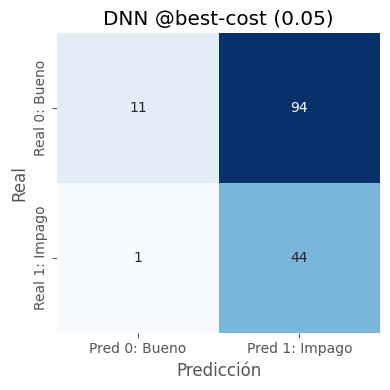

In [55]:
# Evaluaci√≥n en test con umbral de costo (se usa DNN simple como ejemplo)
"""
Este bloque de c√≥digo eval√∫a el modelo DNN en el conjunto de prueba usando 
el umbral que minimiza el costo total (en validaci√≥n). 
Se imprimen las m√©tricas principales y se muestra la matriz de confusi√≥n.
"""

# Recupera el umbral √≥ptimo (m√≠nimo costo) encontrado para el modelo DNN
thr_cost_dnn = cost_best_dnn[1]

# Eval√∫a el desempe√±o del modelo DNN en test con ese umbral
eval_dnn_cost = metrics_at_threshold(y_test, test_prob_dnn, thr_cost_dnn)

# Imprime las m√©tricas (redondeadas a 3 decimales), excepto la matriz de confusi√≥n
print("üîπ [DNN @best-cost]", {k: round(v, 3) for k, v in eval_dnn_cost.items() if k != 'cm'})

# Grafica la matriz de confusi√≥n con el umbral aplicado
plot_cm(eval_dnn_cost["cm"], f"DNN @best-cost ({thr_cost_dnn:.2f})")

In [56]:
# Reporte de clasificaci√≥n (ResNet @best-F1)
y_pred_dnn_bf = (test_prob_dnn >= eval_dnn_bf["thr"]).astype(int)
print("üìú Reporte de clasificaci√≥n (DNN simple @best-F1)\n")
print(classification_report(y_test, y_pred_dnn_bf, target_names = ["Bueno (0)","Impago (1)"]))

üìú Reporte de clasificaci√≥n (DNN simple @best-F1)

              precision    recall  f1-score   support

   Bueno (0)       0.83      0.65      0.73       105
  Impago (1)       0.46      0.69      0.55        45

    accuracy                           0.66       150
   macro avg       0.64      0.67      0.64       150
weighted avg       0.72      0.66      0.67       150



üìà **Evaluaci√≥n del modelo y an√°lisis de errores Tipo I/II (contexto financiero)**

A continuaci√≥n se analiza el desempe√±o de **DNN simple** y **ResNet tabular** en *test*, usando tres criterios de decisi√≥n:
- **Umbral fijo 0.5**
- **Umbral que maximiz√≥ F1 en validaci√≥n** (best‚ÄëF1)
- **Umbral que minimiz√≥ costo en validaci√≥n** (best‚Äëcost; costo(FP)=1, costo(FN)=10)

> Definici√≥n de clases: **1 = Impago (riesgoso)**, **0 = Bueno**.  
> **FP (Tipo I)**: rechazar a un buen cliente.  
> **FN (Tipo II)**: aprobar a un cliente que impaga.

---

**1. M√©tricas principales observadas**

üîπ **DNN @ 0.50**
- **CM**: TN=78, FP=27, FN=17, TP=28  
- **Accuracy** 0.707 ¬∑ **Precision** 0.509 ¬∑ **Recall** 0.622 ¬∑ **F1** 0.560 ¬∑ **AUC** 0.770  
- **Aceptaci√≥n** (pred. buenos) = (TN+FN)/N = 95/150 = **63.3%**

üîπ **DNN @ best‚ÄëF1 (0.40, aprendido en validaci√≥n)**
- **CM**: TN=68, FP=37, FN=14, TP=31  
- **Accuracy** 0.660 ¬∑ **Precision** 0.456 ¬∑ **Recall** 0.689 ¬∑ **F1** 0.549 ¬∑ **AUC** 0.770  
- **Aceptaci√≥n** = 82/150 = **54.7%**

üîπ **ResNet @ 0.50  *(best‚ÄëF1 coincide con 0.50)***
- **CM**: TN=76, FP=29, FN=13, TP=32  
- **Accuracy** 0.720 ¬∑ **Precision** 0.525 ¬∑ **Recall** 0.711 ¬∑ **F1** 0.604 ¬∑ **AUC** 0.767  
- **Aceptaci√≥n** = 89/150 = **59.3%**

üîπ **DNN @ best‚Äëcost (0.05, costo FP:FN = 1:10)**
- **CM**: TN=11, FP=94, FN=1, TP=44  
- **Accuracy** 0.367 ¬∑ **Precision** 0.319 ¬∑ **Recall** **0.978** ¬∑ **F1** 0.481 ¬∑ **AUC** 0.770  
- **Aceptaci√≥n** = 12/150 = **8%** (rechazo masivo)

> **AUC** ‚âà 0.77 en ambos modelos: la capacidad de ranking es similar; las diferencias vienen de **d√≥nde fijamos el umbral**.

---

**2. Costeo de errores y trade‚Äëoffs**

Usamos la funci√≥n de costo esperada:

$Costo = FP * C_FP + FN * C_FN$

Con C_FP = 1 y C_FN = 10 (FN es 10 veces m√°s caro que FP).

- **DNN @0.50** ‚Üí 27¬∑1 + 17¬∑10 = **197**
- **DNN @0.40** ‚Üí 37¬∑1 + 14¬∑10 = **177**
- **ResNet @0.50** ‚Üí 29¬∑1 + 13¬∑10 = **159**
- **DNN @best‚Äëcost (0.05)** ‚Üí 94¬∑1 + 1¬∑10 = **104**

**Lecturas clave**
- Con **relaci√≥n de costos 10:1**, el **umbral muy bajo (0.05)** de DNN **minimiza costo** al **maximizar recall (0.978)** y casi eliminar FN, a costa de much√≠simos FP (**rechazo 92%**).  
- Entre umbrales razonables (aceptaci√≥n 55‚Äì65%), **ResNet @0.50** domina a DNN (menor FN y F1 m√°s alto) y ofrece el **menor costo (159)** sin colapsar la tasa de aprobaci√≥n.

**Punto de equilibrio de costos** entre DNN@best‚Äëcost y ResNet@0.5:

$94 + 1 * r = 29 + 13 * r$

$‚áí r = 65 / 12 ‚âà 5.42$

- Si $CFN‚Äã/CFP‚Äã<5.42$ ‚Üí conviene **ResNet @0.50**.  
- Si $CFN‚Äã/CFP‚Äã>5.42$ ‚Üí conviene **bajar el umbral** de forma agresiva (similar a DNN@0.05).

---

**3. Consecuencias financieras de FP y FN**

üîπ **FP (Tipo I) ‚Äî Rechazar a un buen cliente**
- **Costos**: p√©rdida del margen de inter√©s y comisiones, costo de adquisici√≥n del cliente, potencial churn reputacional.
- **Severidad**: normalmente **menor** que FN por unidad, pero **frecuentes** si ponemos umbrales muy bajos.
- **En DNN@0.05**: 94 FP/105 buenos ‚Üí se rechaza ~**90% de buenos** ‚Üí p√©rdida de ingresos y posible impacto reputacional/regulatorio (pr√°cticas demasiado restrictivas).

üîπ **FN (Tipo II) ‚Äî Aprobar a un cliente que impaga**
- **Costos**: p√©rdida de principal √ó LGD (recuperaci√≥n neta), gastos operativos y legales.  
- **Severidad**: alta por unidad ‚Üí justifica **recall** elevado para la clase 1.  
- **En ResNet@0.50**: 13 FN/45 riesgosos (recall 0.711) ‚Üí buena captura de riesgo con aceptaci√≥n ~59%.

> **Regla pr√°ctica**: si la **p√©rdida esperada** por un default (EAD√óLGD) es **> 5.4√ó** el margen neto perdido por rechazar a un buen cliente, conviene operar con un **umbral m√°s bajo** que incremente el **recall** incluso sacrificando precisi√≥n.

---

**4. Recomendaci√≥n operativa**

1. **Modelo**: operar con **ResNet @ 0.50** como baseline.  
   - Mejor **F1**, **recall** m√°s alto (0.711 vs 0.622 en DNN@0.5), **menor costo** que DNN para relaciones de costo ‚â§ 5.4.  
   - **Aceptaci√≥n** ‚âà **59%** (razonable comercialmente).

2. **Umbral por objetivo de negocio**:
   - Si el banco busca **minimizar p√©rdidas crediticias** y puede tolerar rechazo adicional, mover el umbral **por debajo de 0.5** hasta lograr el **recall objetivo** (p.ej., ‚â•0.80) **con una tasa de aprobaci√≥n m√≠nima acordada** (p.ej., ‚â•45‚Äì50%).  
   - Si se prioriza **volumen/penetraci√≥n** (alta aprobaci√≥n), subir umbral (‚â•0.55) controlando FN v√≠a **pol√≠ticas complementarias** (garant√≠as, l√≠mites de monto, pricing).

3. **Optimizaci√≥n con restricci√≥n** (recomendado):
   - Elegir umbral **que minimice costo** **sujeto** a una **tasa de aprobaci√≥n m√≠nima** (por ejemplo, ‚â•50%) y/o a l√≠mites regulatorios de disparidad (fair lending).  
   - Esto evita la soluci√≥n trivial de ‚Äúrechazar casi todo‚Äù (como DNN@0.05).

4. **Pricing y l√≠mites**:
   - Para scores cercanos al umbral, aplicar **tasas/seguros** ajustados al riesgo o **reducir EAD** (monto/plazo) para disminuir la p√©rdida esperada sin rechazar masivamente.

5. **Monitoreo**:
   - **Estabilidad del umbral** y **drift** de datos (PSI/KS).  
   - **Calibraci√≥n** de probabilidades (Platt/Isot√≥nica) para que el score sea interpretable como **PD** y pueda integrarse con LGD/EAD en el c√°lculo de **EL = PD√óLGD√óEAD**.

---

**5. Lectura complementaria de F1 y ROC**

- **F1** pondera precisi√≥n y recall de la clase 1; en **ResNet @0.50** es **0.604** (mejor que DNN 0.560).  
- **ROC‚ÄëAUC ‚âà 0.77** (ambos): la **curva ROC** sugiere que, moviendo el umbral, es posible **intercambiar FPR por TPR**; por eso la **pol√≠tica de umbrales** debe alinearse a **costos** y **tasa de aprobaci√≥n** objetivo.

---

**6. ¬øQu√© har√≠a distinto si cambian los costos?**

- Si el margen por cliente bueno rechazado es **alto** (p.ej., productos de alto spread, cross‚Äësell fuerte), **subir√≠a** el umbral para **reducir FP**.  
- Si el **LGD** esperado por default es elevado (colaterales d√©biles, recobro bajo), **bajar√≠a** el umbral para **reducir FN**.

---

üß© **Resumen**
- **Capacidad de ranking (AUC) similar** en ambos modelos; la **ResNet @0.50** logra **mejor F1 y recall**, con **menor costo** que DNN para relaciones de costo realistas (‚â§5.4).  
- **Umbral extremo (0.05)** minimiza costo con ratio 10:1 pero **inviable comercialmente** (aceptaci√≥n ~8%).  
- **Pol√≠tica recomendada**: seleccionar umbral por **minimizaci√≥n de costo sujeta a tasa de aprobaci√≥n m√≠nima**, con **pricing/garant√≠as** en la franja lim√≠trofe y **monitoreo** continuo de drift y fairness.

#### <strong><font color="green">6. Reflexi√≥n cr√≠tica</font></strong>

üß† **Reflexi√≥n Cr√≠tica sobre el Modelo de Riesgo Crediticio**

El uso de modelos de *Machine Learning* en el √°mbito financiero, en particular para la predicci√≥n de riesgo crediticio, plantea oportunidades significativas pero tambi√©n desaf√≠os √©ticos y t√©cnicos que deben ser considerados con cuidado.

---

üîç **√âtica y posibles sesgos**

El modelo identifica variables como el **estatus financiero previo**, los **ahorros declarados** y la **historia crediticia** como factores determinantes. Sin embargo, es crucial reflexionar sobre la posible introducci√≥n de **sesgos hist√≥ricos**: si los datos de entrenamiento reflejan pr√°cticas discriminatorias (ej. diferencias por g√©nero, edad o estado civil), el modelo puede reproducir y amplificar esas inequidades. Adem√°s, decisiones de *feature engineering* no siempre est√°n documentadas de forma transparente, lo que dificulta evaluar si todas las variables utilizadas son justificables desde una perspectiva √©tica.

Otro aspecto clave es el **balance entre falsos positivos y falsos negativos**. En este caso, se defini√≥ un costo 10 veces mayor para los falsos negativos, lo que refleja una prioridad en minimizar pr√©stamos otorgados a clientes que no podr√°n pagar. Si bien esto es razonable desde el punto de vista financiero, tambi√©n implica un riesgo √©tico: se puede limitar injustamente el acceso al cr√©dito a clientes solventes que, debido a patrones complejos en los datos, son clasificados err√≥neamente como de alto riesgo.

---

üìä **Explicabilidad hacia equipos de riesgo bancario**

Un valor agregado del an√°lisis es el uso de t√©cnicas de **explicabilidad** (SHAP), que permiten mostrar con claridad qu√© variables influyen en las predicciones. Estas gr√°ficas facilitan que un equipo de riesgo bancario, incluso sin formaci√≥n t√©cnica profunda, entienda que el modelo no es una ‚Äúcaja negra‚Äù, sino que existen factores observables que gu√≠an las decisiones. Variables como el **estatus crediticio previo** y la **duraci√≥n del cr√©dito solicitado** se identifican como determinantes, lo que es coherente con pr√°cticas bancarias tradicionales.

No obstante, para ser totalmente explicable en un comit√© de riesgo, se requiere:
- Documentar en lenguaje claro la justificaci√≥n de cada variable incluida.
- Mostrar ejemplos de decisiones a nivel individual, indicando c√≥mo cada caracter√≠stica del cliente impact√≥ en su evaluaci√≥n.
- Discutir escenarios de umbrales de decisi√≥n, vincul√°ndolos al costo esperado de errores tipo I (falsos positivos) y tipo II (falsos negativos).

---

‚úÖ **Conclusi√≥n**

El modelo es t√©cnicamente s√≥lido y se apoya en herramientas modernas de explicabilidad, lo que facilita su adopci√≥n en un entorno bancario. Sin embargo, a√∫n persisten **desaf√≠os √©ticos y de transparencia**: es necesario auditar los datos de entrenamiento para mitigar sesgos y garantizar que el sistema no discrimine a ciertos segmentos de clientes. Adem√°s, se debe acompa√±ar la implementaci√≥n con documentaci√≥n clara y discusiones interdisciplinarias (riesgo, legal, √©tica) para asegurar que las decisiones automatizadas sean justas, trazables y alineadas con la responsabilidad social del banco.

---